In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import confusion_matrix

import os

In [ ]:
# path to project: Edit here to point to your Drive
drive = '/content/drive/MyDrive/'
project_dir = 'Colab Notebooks/IronHacks2024_Data_Analytics/DA_Week_8-9_Final_Project'
COLAB_PROJECT_PATH = drive+project_dir+'/Final_Project/'

In [ ]:
# Mount Google Drive
using_colab = False
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    using_colab = True

if using_colab and os.path.exists(COLAB_PROJECT_PATH):
    print('found colab path; redirecting to main project directory')
    os.chdir(COLAB_PROJECT_PATH)

Mounted at /content/drive
found colab path; redirecting to main project directory


### Import Cleaned data

In [ ]:
vg_data = pd.read_csv('./Clean_Data/vg_sales_cleaned.csv')
if 'Unnamed: 0' in vg_data.columns:
    vg_data.drop('Unnamed: 0', axis=1, inplace=True)
vg_data.isna().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Critic_Score    0
User_Score      0
dtype: int64

## Binning:
- bin publisher data into high, medium, low
- bin games by name (differentiatd by platform release),
    - Summing sales data for each region
    - getting avg critic/user score

In [ ]:
for col in ['Name','Platform', 'Genre', 'Publisher']:
    print(f'{col} has {vg_data[col].nunique()} values')

Name has 12027 values
Platform has 25 values
Genre has 17 values
Publisher has 645 values


In [ ]:
def bin_publisher(vg_dataframe):
    """
    bins the publishers into low-profile, med-profile, high-profile
    arguments: vg_dataframe (pd.DataFrame) - the video_game dataframe
                                             with publisher data
    """
    # thresholds for medium and high profiie
    medium = 50
    high = 500

    # Counts of each publisher
    publisher_counts = vg_dataframe['Publisher'].value_counts()

    # Create a dictionary to map publishers to their profile categories
    profile_mapping = {}

    for publisher, count in publisher_counts.items():
        if count >= high:
            profile_mapping[publisher] = 'High Profile'
        elif count >= medium:
            profile_mapping[publisher] = 'Medium Profile'
        else:
            profile_mapping[publisher] = 'Low Profile'

    # Add a new column 'Profile' based on the mapping
    vg_dataframe['Publisher_Profile'] = vg_dataframe['Publisher'].map(profile_mapping)

In [ ]:
bin_publisher(vg_data)
vg_data['Publisher_Profile'].value_counts()

Publisher_Profile
Medium Profile    6808
High Profile      6683
Low Profile       4040
Name: count, dtype: int64

In [ ]:
# convert year to int
vg_data['Year'] = vg_data['Year'].astype(int)

In [ ]:
def filter_data(score_series):
    filter = lambda x: x if (not pd.isna(x) and x >= 1.0) else np.nan
    return score_series.apply(filter)

def combine_game_entries(vg_dataframe):
    """
    Combines the game entries,
    Arguments: vg_dataframe (pd.DataFrame) - the video_game dataframe
    Returns: (pd.DataFrame) combined dataframe
    """

    def concat_platform(plat_data):
        return ', '.join(plat_data)

    game_data = vg_dataframe
    original_cols = game_data.columns

    # Group by 'Name', sum 'Sales', calculate average 'Score' (ignoring scores < 1.0 or NaN)
    # Combine platform releases (plat1, plat2,..., platn)
    critic = 'Critic_Score'
    user = 'User_Score'
    # Filter scores < 1.0 or NaN so they don't influence the agg mean scores
    game_data[critic] = filter_data(game_data[critic])
    game_data[user] = filter_data(game_data[user])

    sales = {sale_region: 'sum' for sale_region in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']}
    scores = {score_type: 'mean' for score_type in ['Critic_Score', 'User_Score']}

    combined_data = game_data.groupby('Name').agg({**sales, **scores, \
                                                   'Platform': concat_platform}).reset_index()
    combined_data['Critic_Score'].fillna(0.0, inplace=True)
    combined_data['User_Score'].fillna(0.0, inplace=True)

    # Get remaining data to merge with the aggregated data
    remaining_cols = ['Rank','Name','Year','Genre','Publisher','Publisher_Profile']
    remaining_data = game_data[remaining_cols].drop_duplicates(subset='Name')
    print(remaining_data.shape)

    all_vg_data = pd.merge(combined_data, remaining_data, on='Name')
    all_vg_data.sort_values('Rank', ascending=True, ignore_index=True, inplace=True)
    all_vg_data = all_vg_data[original_cols]

    return all_vg_data

In [ ]:
vg_games_data = combine_game_entries(vg_data)
vg_games_data

(12027, 6)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,User_Score,Publisher_Profile
0,32,Wii Sports,Wii,2006,Sports,Nintendo,41.36,29.02,3.77,8.51,7.7,0.0,High Profile
1,52,Mario Kart 8 Deluxe,NS,2017,Racing,Nintendo,5.05,4.98,2.11,0.91,9.3,0.0,High Profile
2,81,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,10.0,8.2,High Profile
3,87,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.91,12.92,3.80,3.35,8.2,9.1,High Profile
4,94,Tetris,"GB, NES",1989,Puzzle,Nintendo,26.17,2.95,6.03,0.69,0.0,0.0,High Profile
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,20793,1/2 Summer +,PSP,2013,Misc,Kaga Create,0.00,0.00,0.01,0.00,0.0,0.0,Low Profile
12023,20797,Pippa Funnell 2: Farm Adventures,DS,2007,Simulation,Ubisoft,0.00,0.01,0.00,0.00,0.0,0.0,High Profile
12024,20798,Irotoridori no Sekai: World's End Re-Birth,PSV,2015,Action,HuneX,0.00,0.00,0.01,0.00,0.0,0.0,Low Profile
12025,20799,PDC World Championship Darts 2009,Wii,2009,Sports,Oxygen Interactive,0.00,0.01,0.00,0.00,0.0,0.0,Low Profile


In [ ]:
vg_games_data.dtypes

Rank                   int64
Name                  object
Platform              object
Year                   int64
Genre                 object
Publisher             object
NA_Sales             float64
EU_Sales             float64
JP_Sales             float64
Other_Sales          float64
Critic_Score         float64
User_Score           float64
Publisher_Profile     object
dtype: object

In [ ]:
print(vg_games_data.shape)
vg_games_data.head(3)

(12027, 13)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,User_Score,Publisher_Profile
0,32,Wii Sports,Wii,2006,Sports,Nintendo,41.36,29.02,3.77,8.51,7.7,0.0,High Profile
1,52,Mario Kart 8 Deluxe,NS,2017,Racing,Nintendo,5.05,4.98,2.11,0.91,9.3,0.0,High Profile
2,81,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,10.0,8.2,High Profile


In [ ]:
vg_games_data.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'User_Score',
       'Publisher_Profile'],
      dtype='object')

In [ ]:
def k_means_data(vg_chart_data, scaler):
    """
    Formats the data for use with k-means model testing:
    - Label Encode Publisher profile
    - One Hot encodes the Genre
    - Scales the sales columns, the critic score column and user score column

    Arguments: vg_chart_data (pd.DataFrame) - the video_game dataframe
               scaler (sklearn scaler) - scaler to normalize sales/scores by
    Returns: (pd.DataFrame) - Encoded/Scaled data for k-means
    """
    # Label Encode Publisher
    label_pub = {'High Profile':2, 'Medium Profile':1, 'Low Profile':0}
    vg_chart_data['Pub_Profile_Encoded'] = vg_chart_data['Publisher_Profile'].map(label_pub)

    # One hot encode Genre
    data_to_encode = vg_chart_data[['Genre']]
    encoder = OneHotEncoder(drop=None).fit(data_to_encode)

    encoded_cols = encoder.get_feature_names_out(input_features=data_to_encode.columns)
    game_data_encoded = pd.DataFrame(encoder.transform(data_to_encode).toarray(), columns=encoded_cols)

    # Scale sales and score (if in data) data
    drop_cols = ['Rank', 'Name', 'Platform', 'Genre', 'Publisher', 'Publisher_Profile', 'Pub_Profile_Encoded']
    data_to_scale = vg_chart_data.drop(drop_cols, axis=1)
    scale = data_to_scale.columns

    transformer = scaler.fit(data_to_scale)
    game_data_norm = transformer.transform(data_to_scale)

    game_data_scaled = pd.DataFrame(game_data_norm, index = data_to_scale.index, \
                                    columns=scale).reset_index(drop=True)

    # Remaining Data (encoded publisher profile)
    remain_data = vg_chart_data[['Pub_Profile_Encoded']]

    # Combine
    kmeans_game_data = pd.concat([remain_data, game_data_encoded, game_data_scaled], axis=1)

    return kmeans_game_data

In [ ]:
vg_kmeans = k_means_data(vg_games_data, MinMaxScaler())
print(vg_kmeans.shape)
vg_kmeans

(12027, 25)


,Pub_Profile_Encoded,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_MMO,Genre_Misc,Genre_Music,Genre_Party,Genre_Platform,...,Genre_Sports,Genre_Strategy,Genre_Visual Novel,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,User_Score
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.674419,1.000000,1.000000,0.368885,0.795327,0.77,0.00
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.930233,0.122099,0.171606,0.206458,0.085047,0.93,0.00
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.186047,0.703095,0.123363,0.666341,0.071963,1.00,0.82
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.720930,0.384671,0.445210,0.371820,0.313084,0.82,0.91
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.279070,0.632737,0.101654,0.590020,0.064486,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.837209,0.000000,0.000000,0.000978,0.000000,0.00,0.00
12023,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.697674,0.000000,0.000345,0.000000,0.000000,0.00,0.00
12024,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.883721,0.000000,0.000000,0.000978,0.000000,0.00,0.00
12025,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.744186,0.000000,0.000345,0.000000,0.000000,0.00,0.00


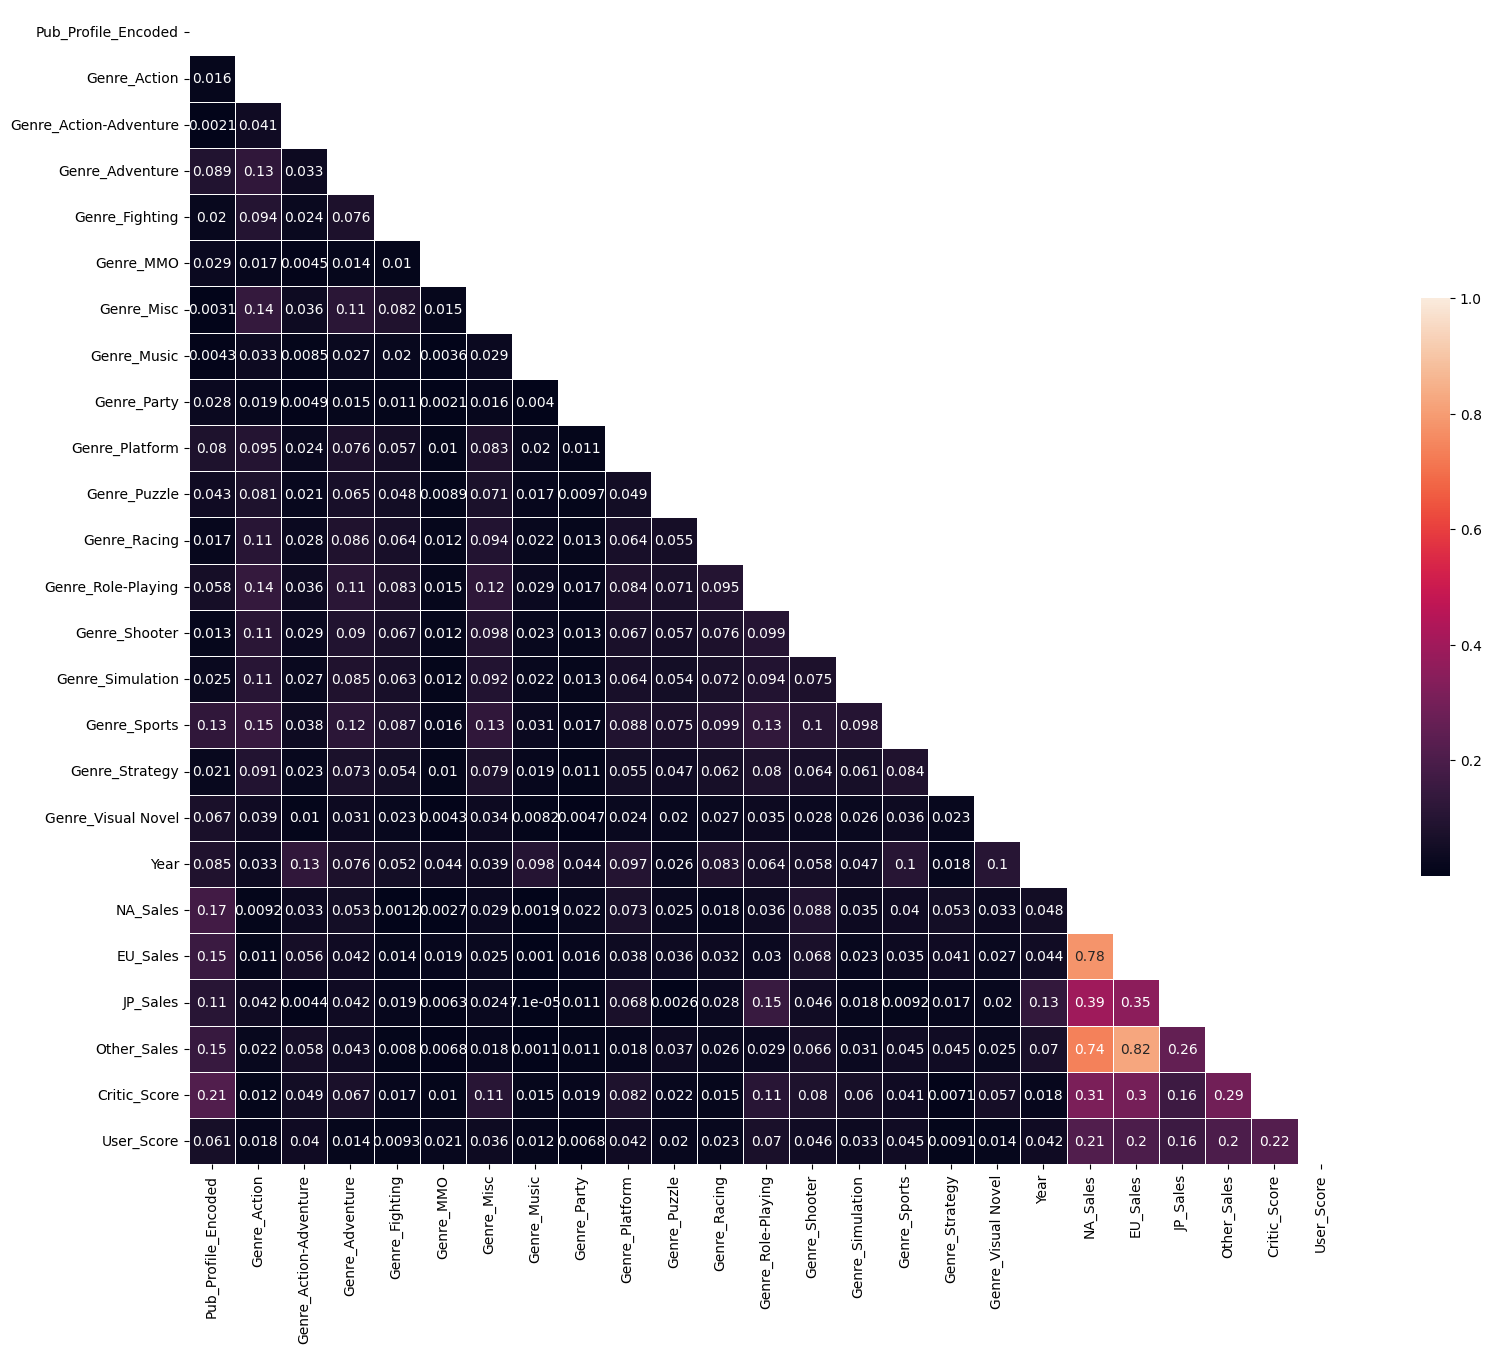

In [ ]:
def corr_tri_map(data):
    corr=np.abs(data.corr())

    #Set up mask for triangle representation
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

    plt.show()

corr_tri_map(vg_kmeans)

### start working on finding optimal K

In [ ]:
def plot_data(k_range, k_measure, plot_ax, plot_info):
    plot_ax.plot(k_range, k_measure, 'bx-')

    plot_ax.set_xlabel(plot_info['xlabel'])
    plot_ax.set_ylabel(plot_info['ylabel'])
    plot_ax.set_xticks(np.arange(min(k_range), max(k_range)+1, 1.0))
    plot_ax.set_title(plot_info['title'])

def graph_optimal_k(vg_kmeans_data, scaler):
    """
    Graphs the optimal k for k-means clustering through looking at:
    - Elbow Method
    - Sihoulette Score

    Arguments:
        vg_kmeans_data (pd.DataFrame) - video game kmeans prepped data
        scaler (sklearn scaler) - scaler to normalize sales/scores by
    """

    # Get inertia and silhoutte scores for each K
    K = range(2, 75)
    inertia = []
    silhouette = []

    for k in K:
        kmeans = KMeans(n_clusters=k,
                        n_init=10,
                        random_state=42)
        kmeans.fit(vg_kmeans_data)
        inertia.append(kmeans.inertia_)

        kmeans_predictions = kmeans.predict(vg_kmeans_data)
        silhouette.append(silhouette_score(vg_kmeans_data, kmeans_predictions))

    # Plot optimal K
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
    elbow_title = 'Elbow Method Showing Optimal K'
    elbow_info = {'xlabel': 'K', 'ylabel': 'inertia','title': elbow_title}

    silhouette_title = 'Silhouette Score Showing Optimal K'
    silhouette_info = {'xlabel': 'K', 'ylabel': 'silhouette score',\
                       'title': silhouette_title}

    plot_data(K, inertia, ax1, elbow_info)
    plot_data(K, silhouette, ax2, silhouette_info)

    plt.tight_layout()
    plt.show()

### Plot Optimal K graphs, tweaking with
- What data to include for clusters (whether to drop sales, scores, or both)
- Which scaler to use for sales/scores

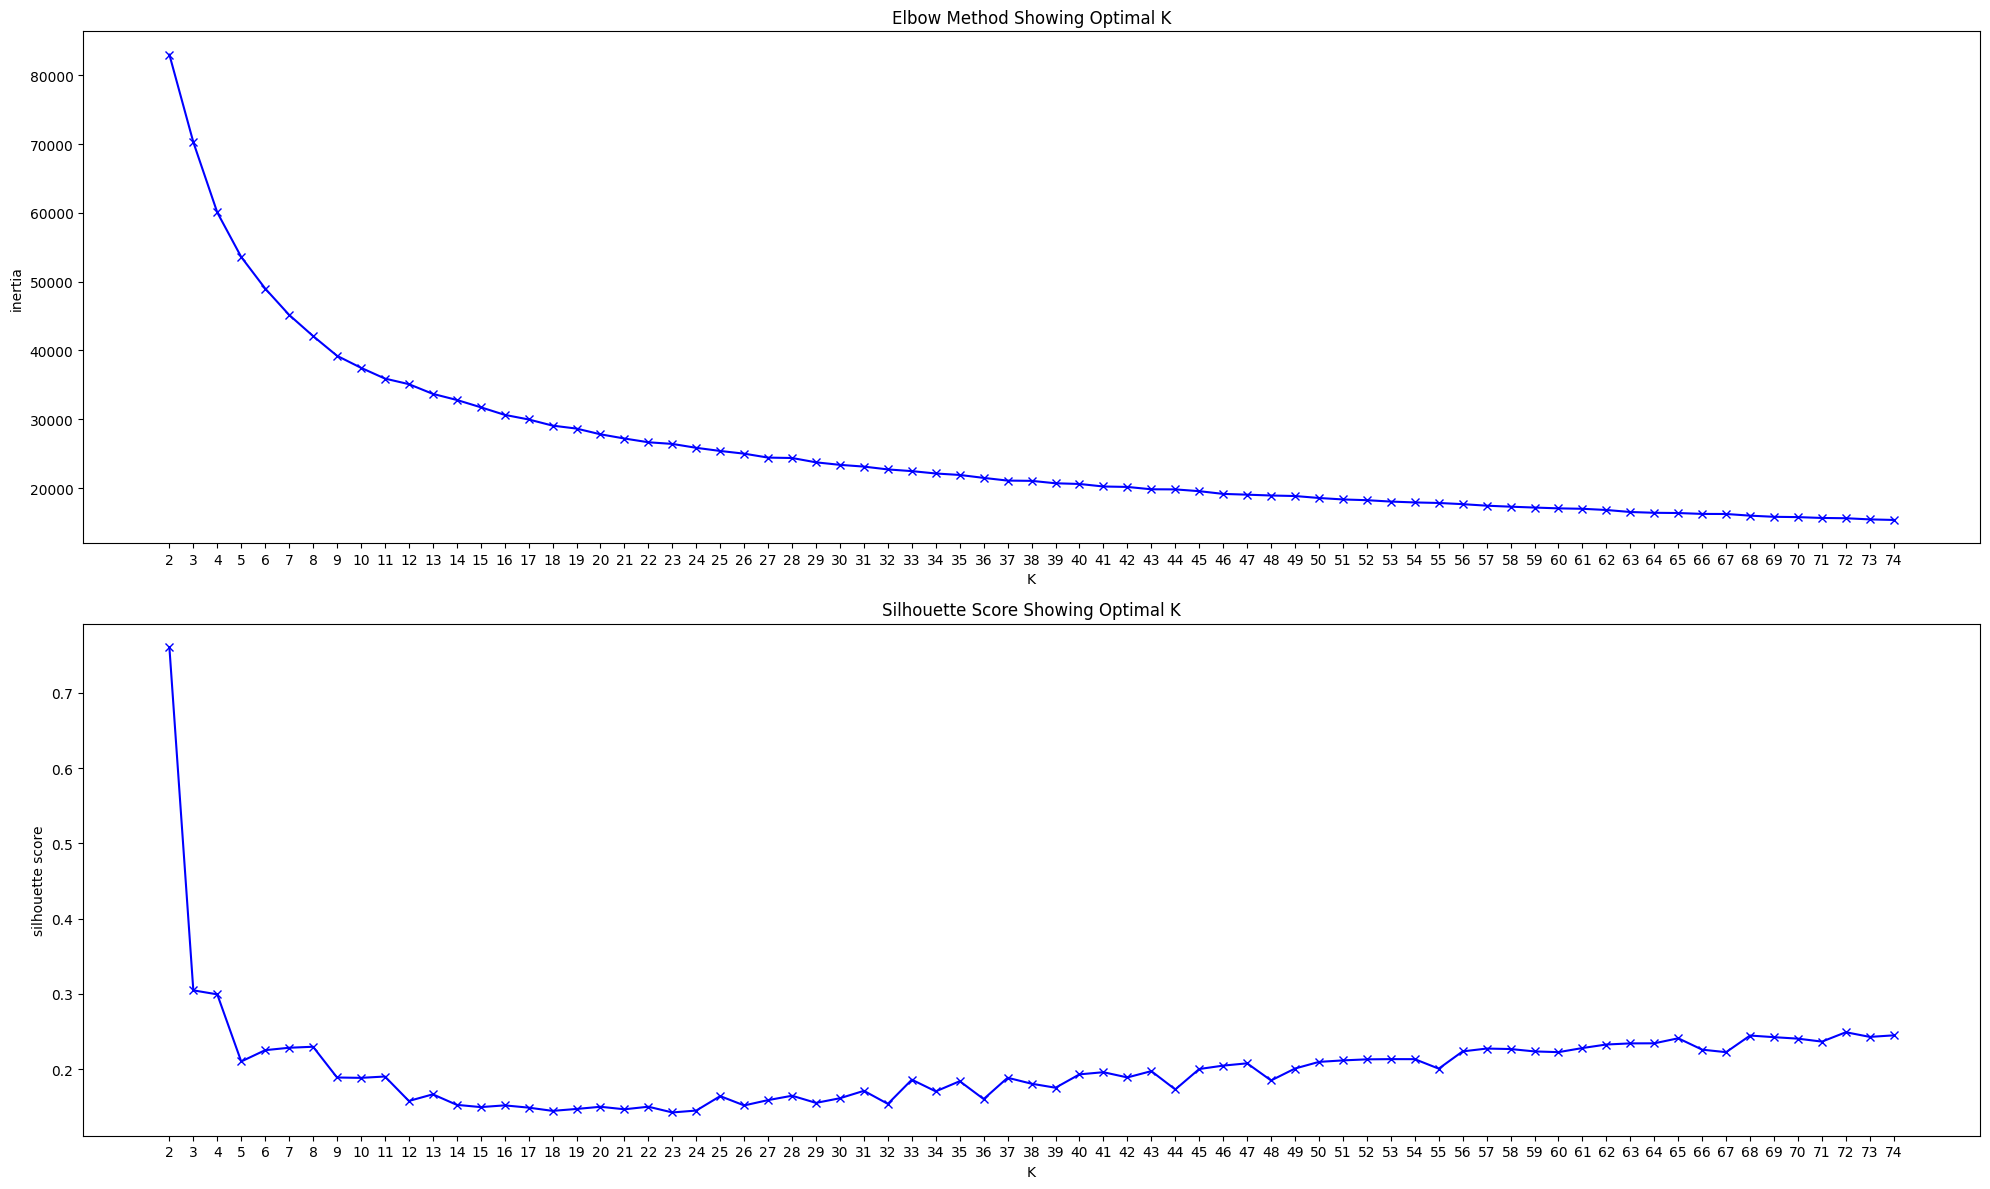

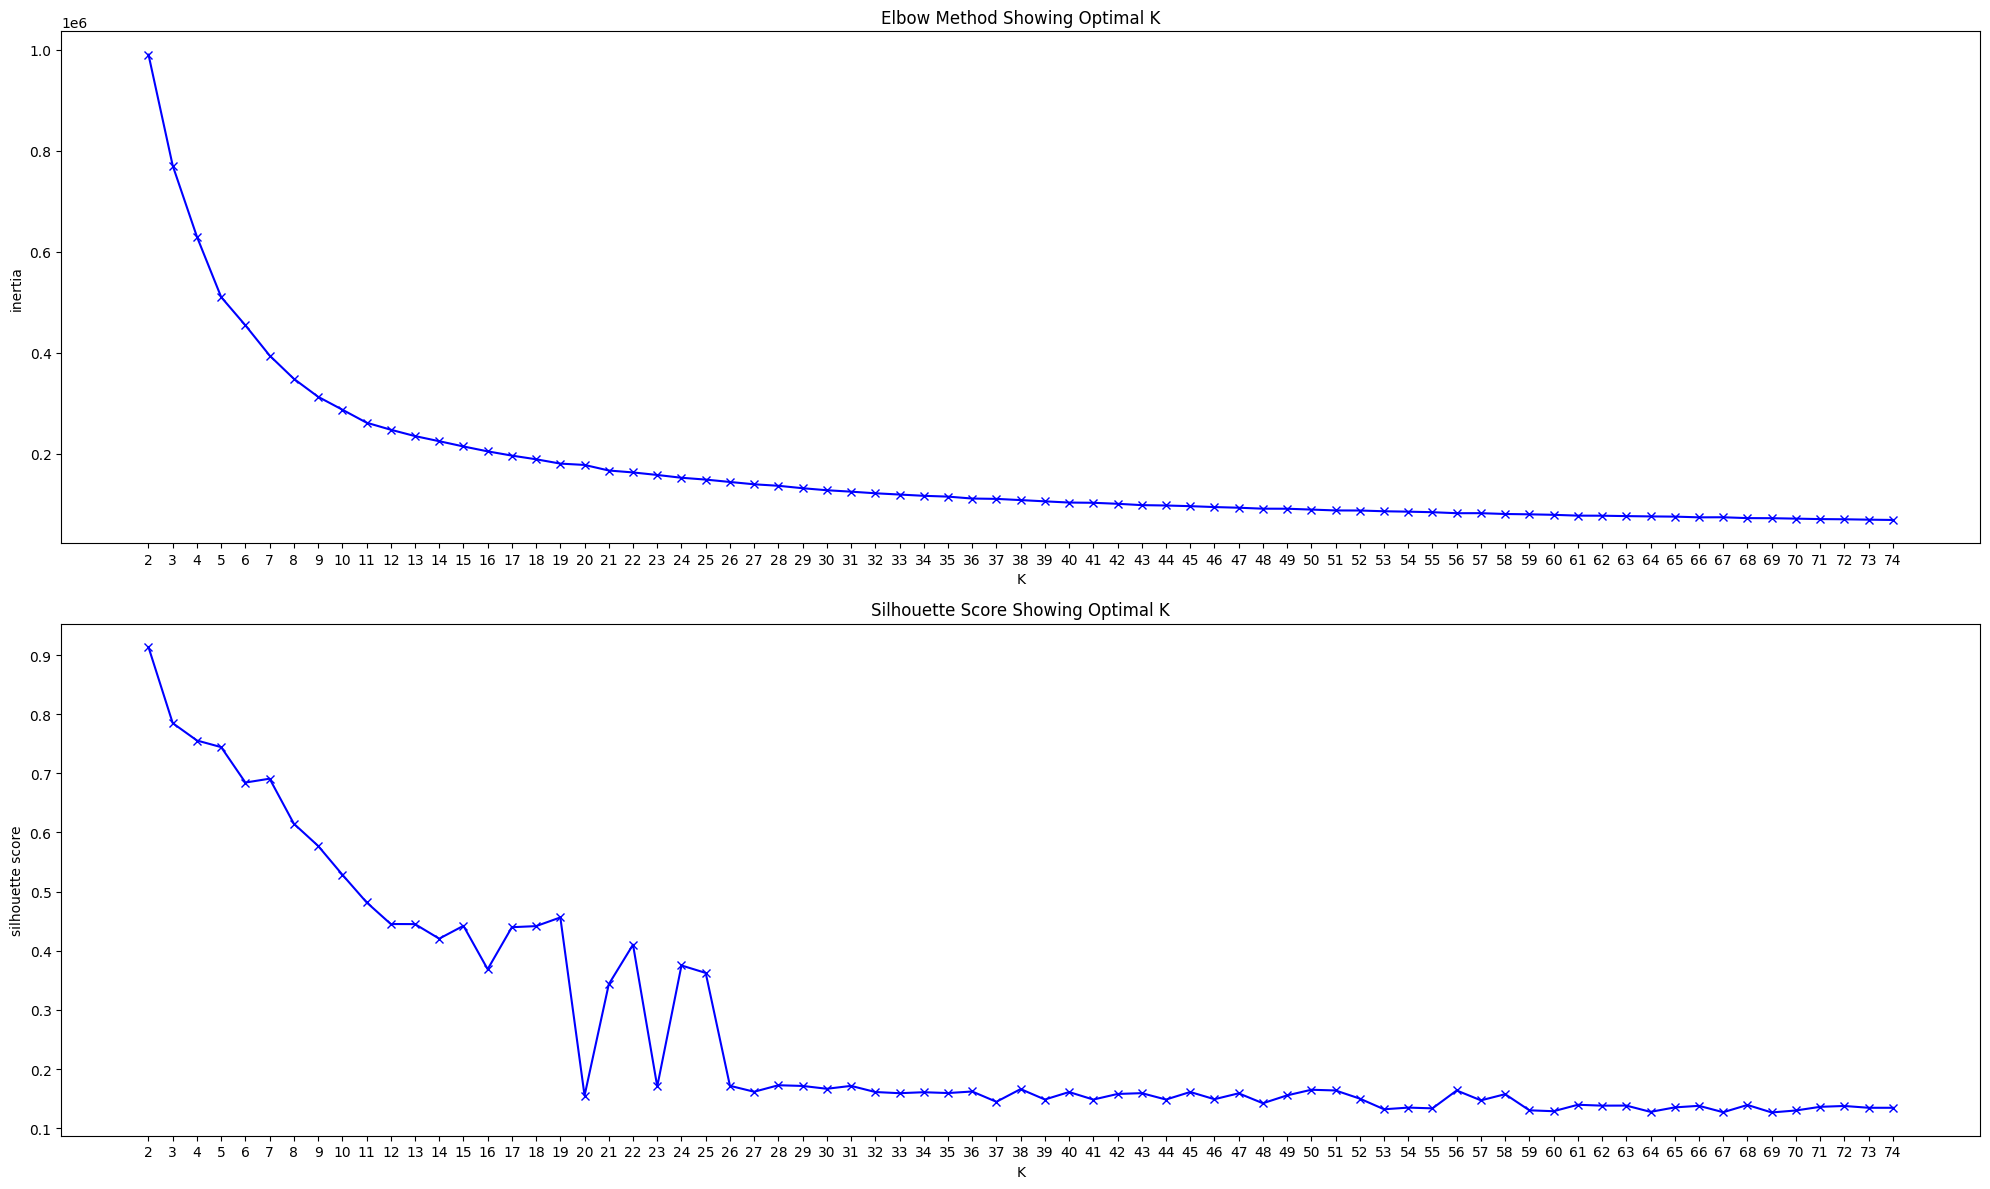

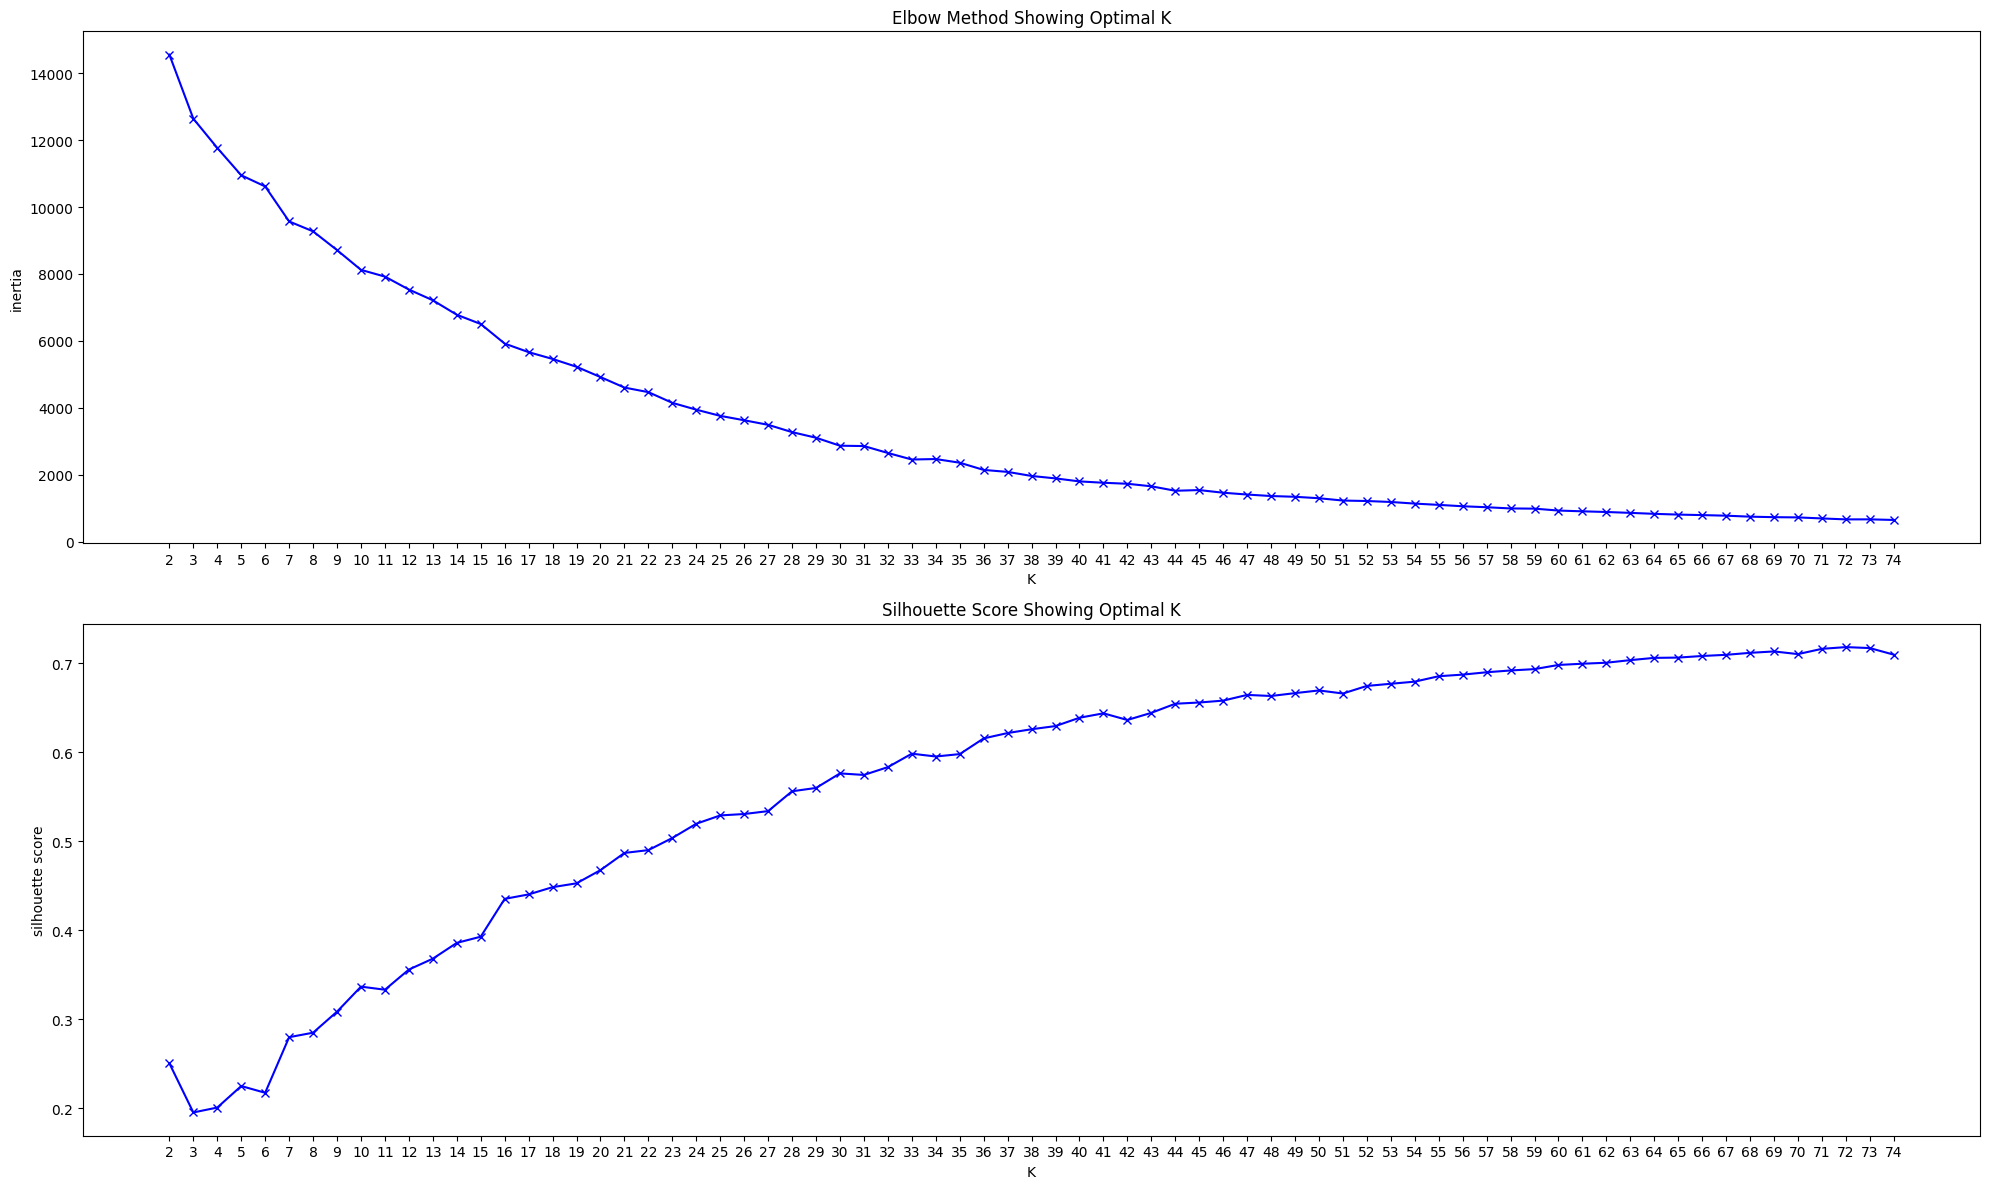

CPU times: user 18min 31s, sys: 5min 40s, total: 24min 12s
Wall time: 16min 20s


In [ ]:
%%time
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for scaler in scalers:
    vg_kmeans_scale = k_means_data(vg_games_data, scaler) # prep data
    graph_optimal_k(vg_kmeans_scale, scaler)

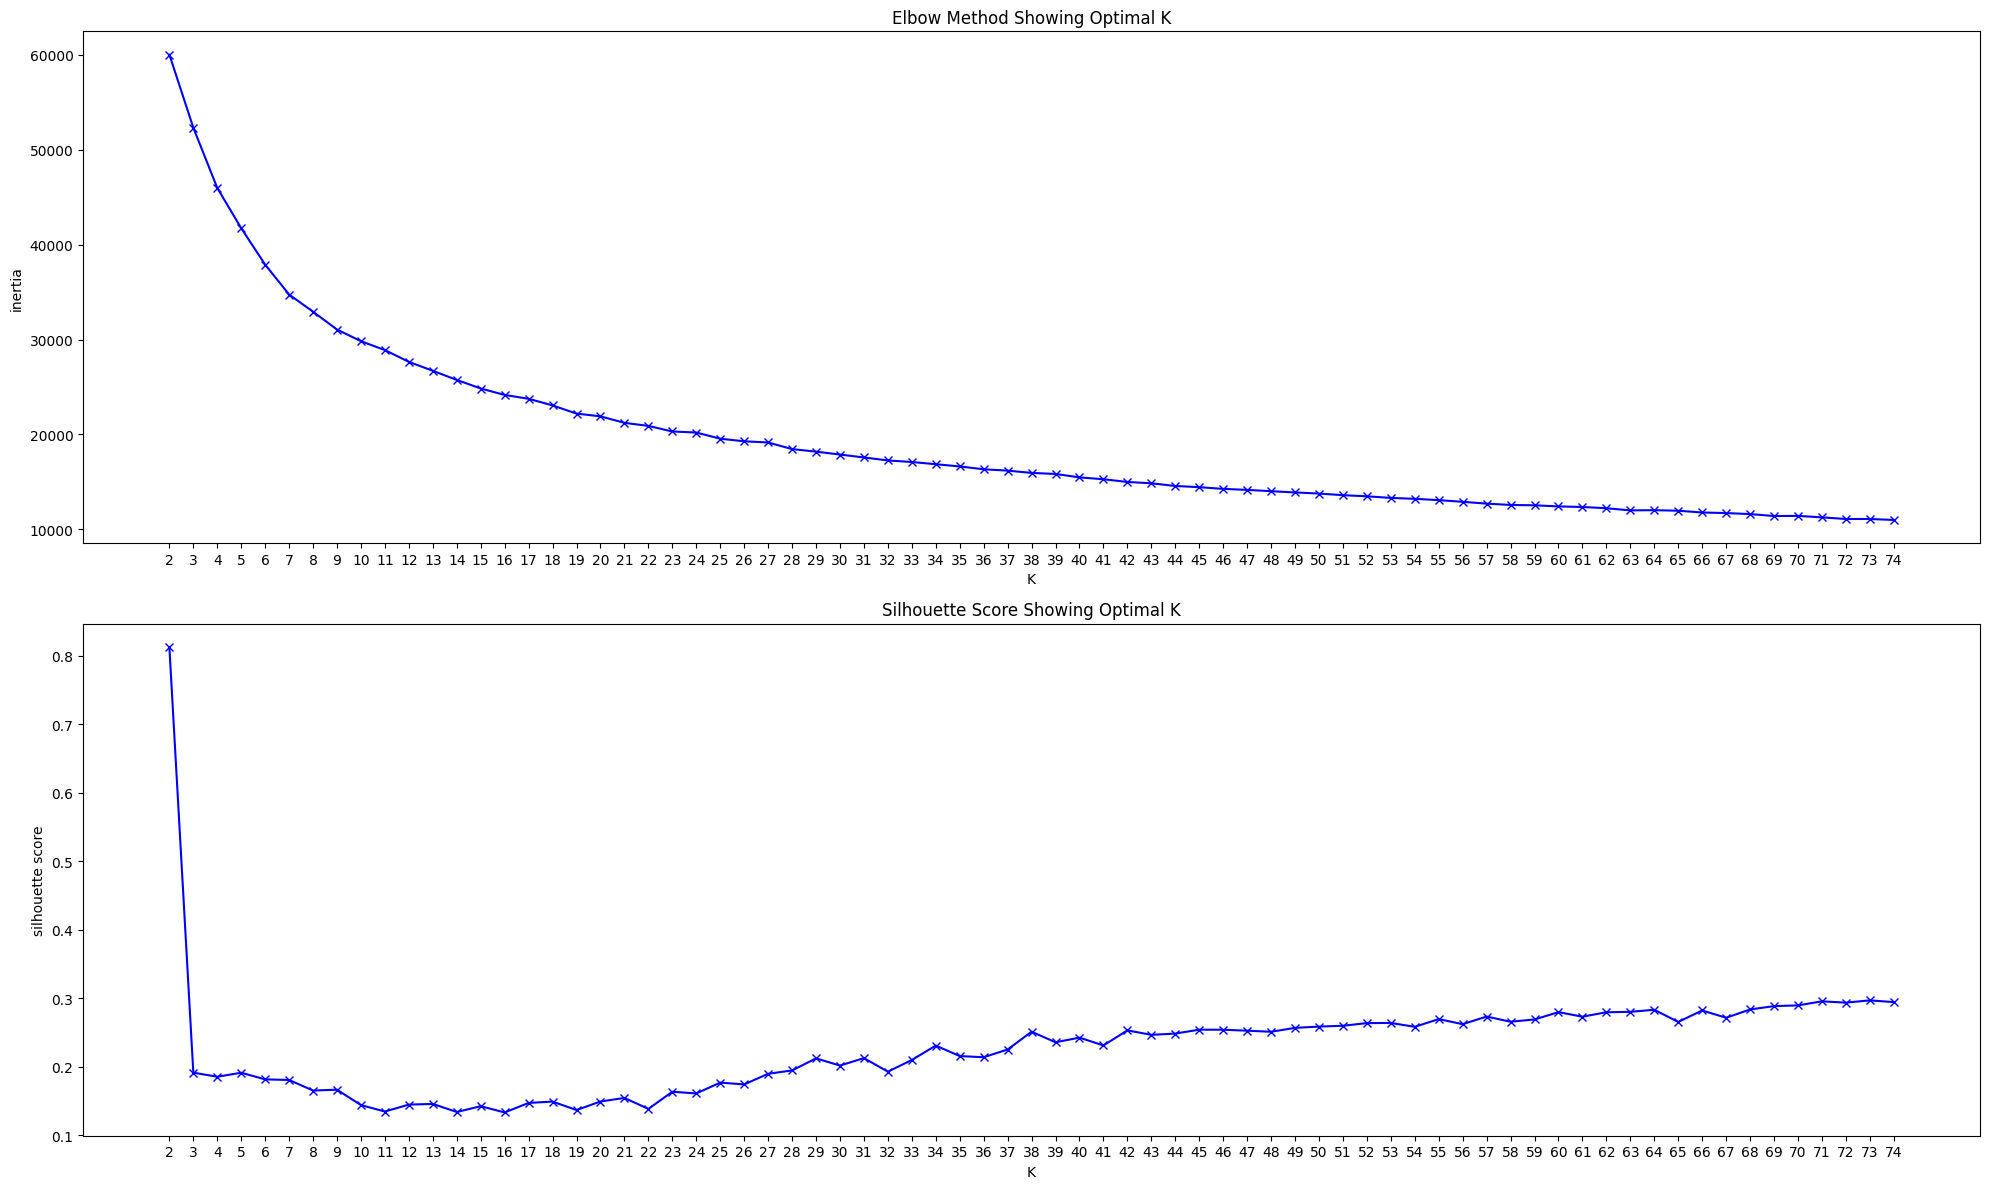

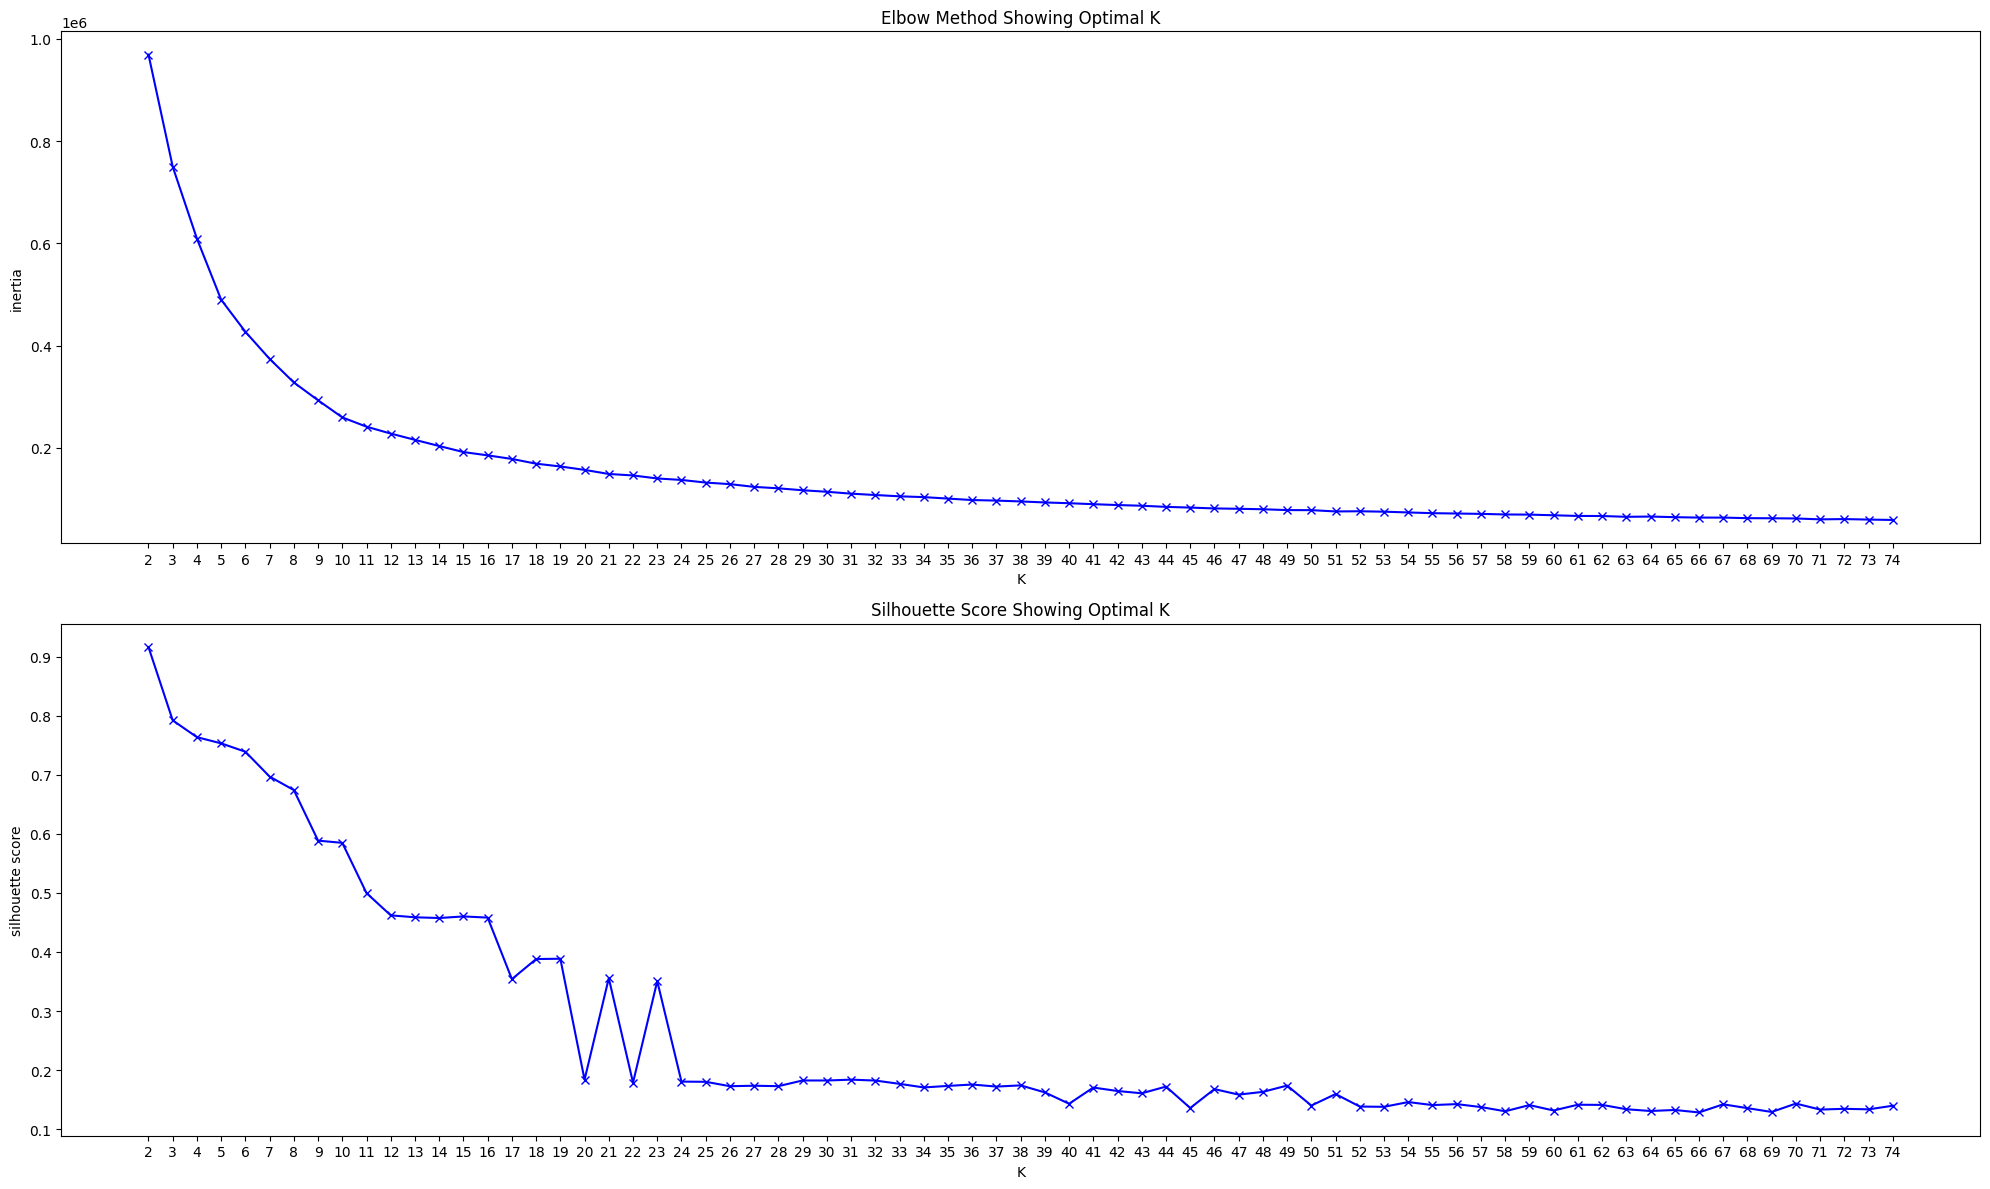

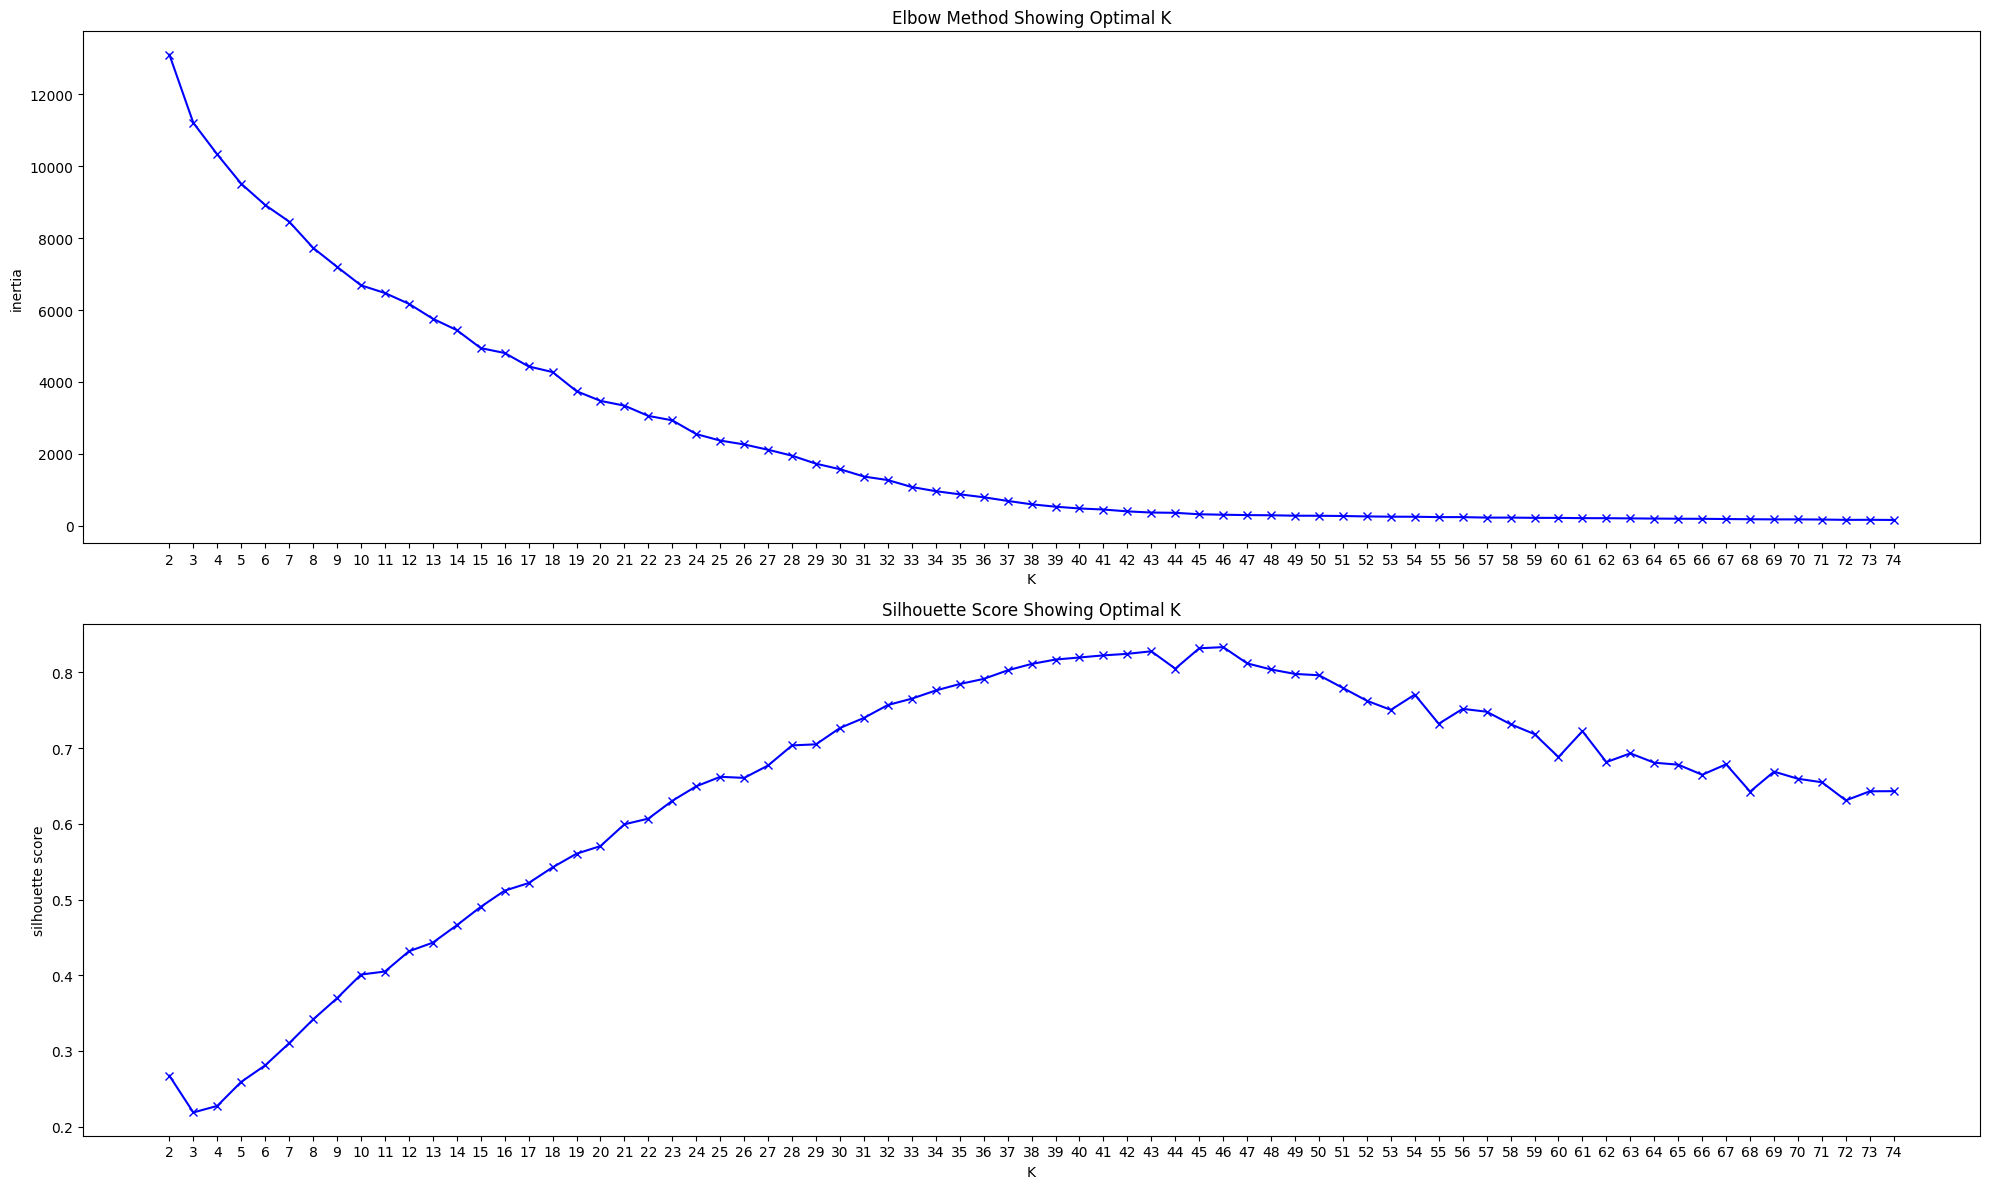

CPU times: user 17min 50s, sys: 5min 41s, total: 23min 32s
Wall time: 15min 39s


In [ ]:
%%time
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for scaler in scalers:
    vg_kmeans_scale = k_means_data(vg_games_data, scaler) # prep data
    graph_optimal_k(vg_kmeans_scale.drop(['Critic_Score', 'User_Score'], axis=1), scaler)

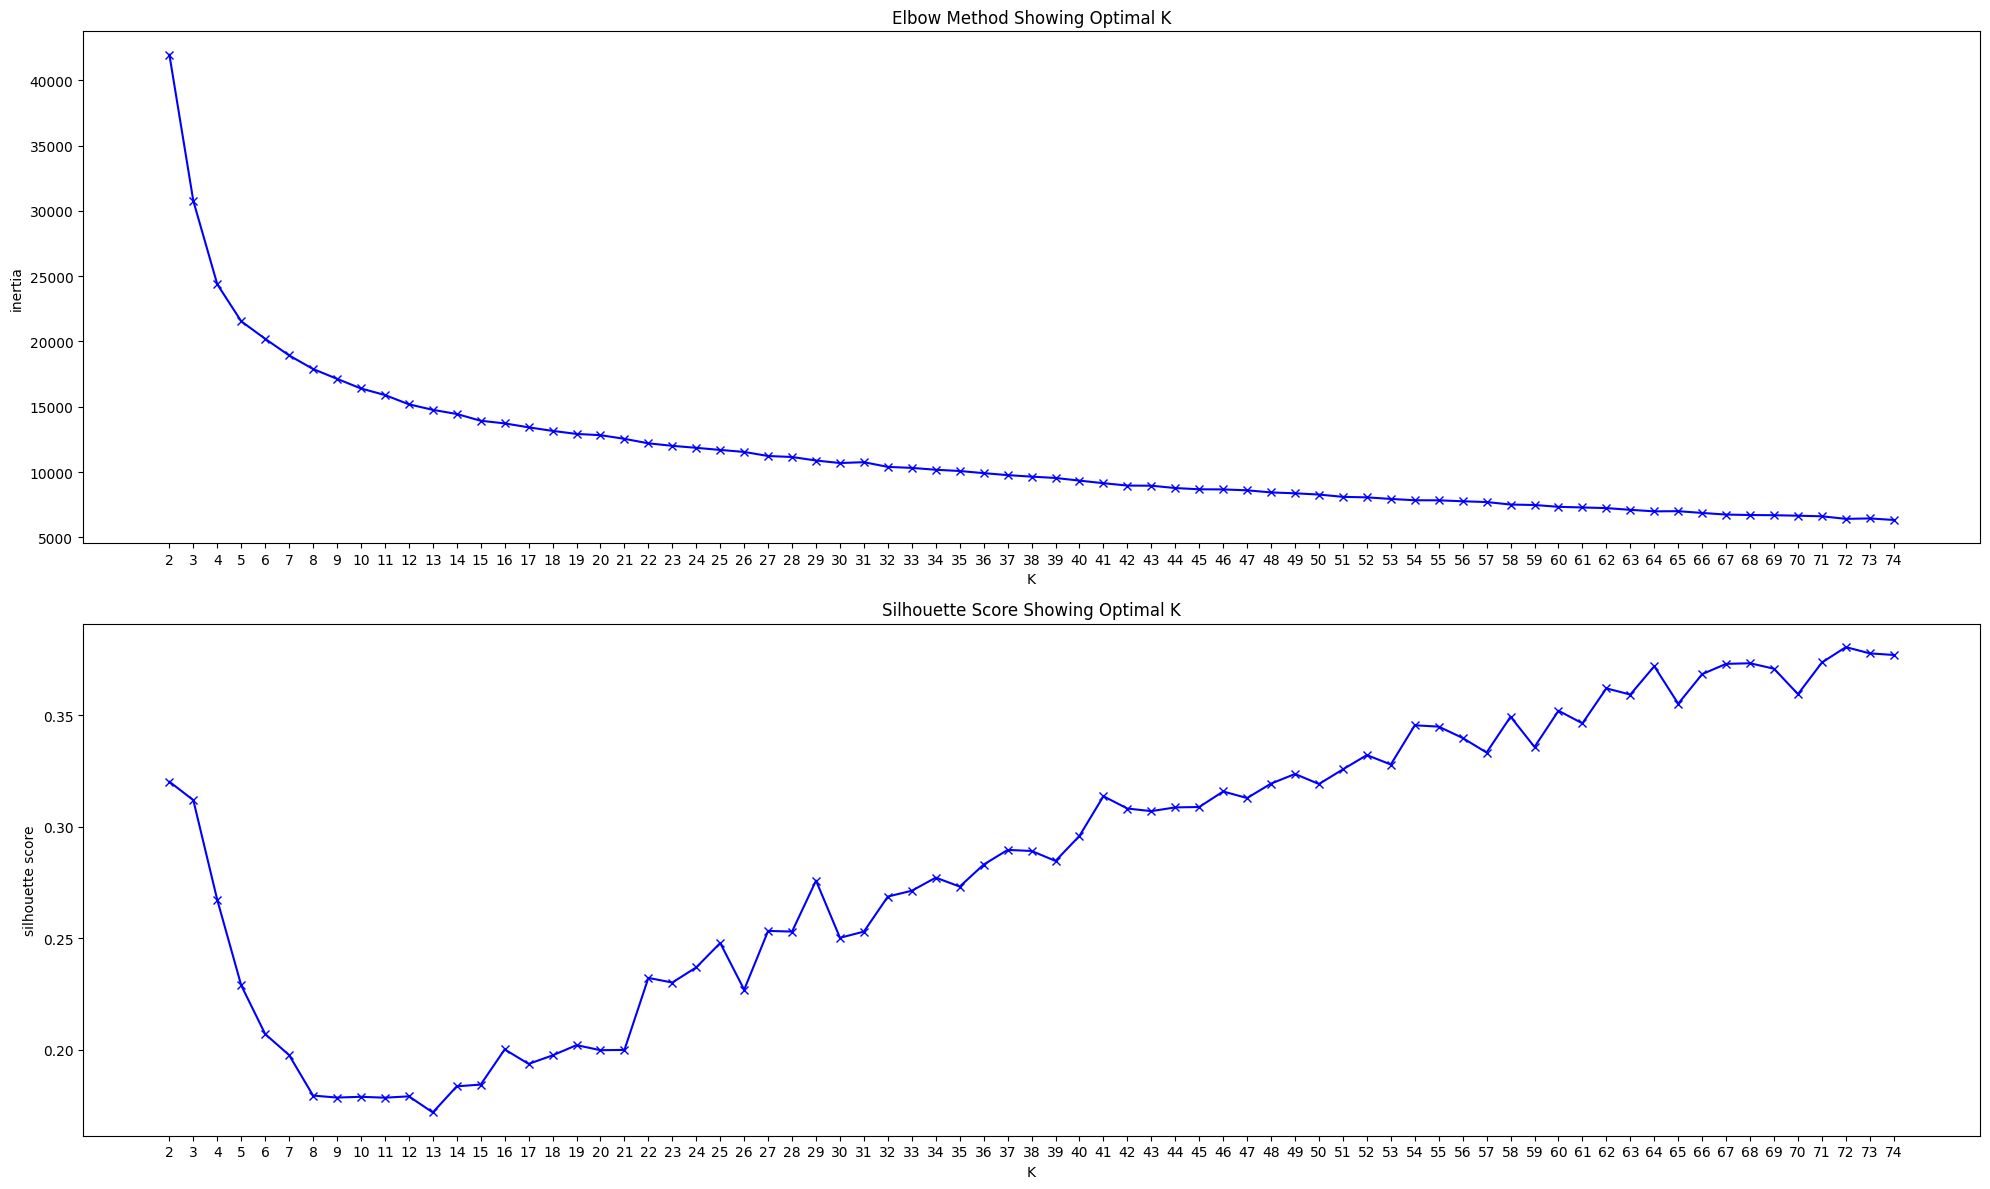

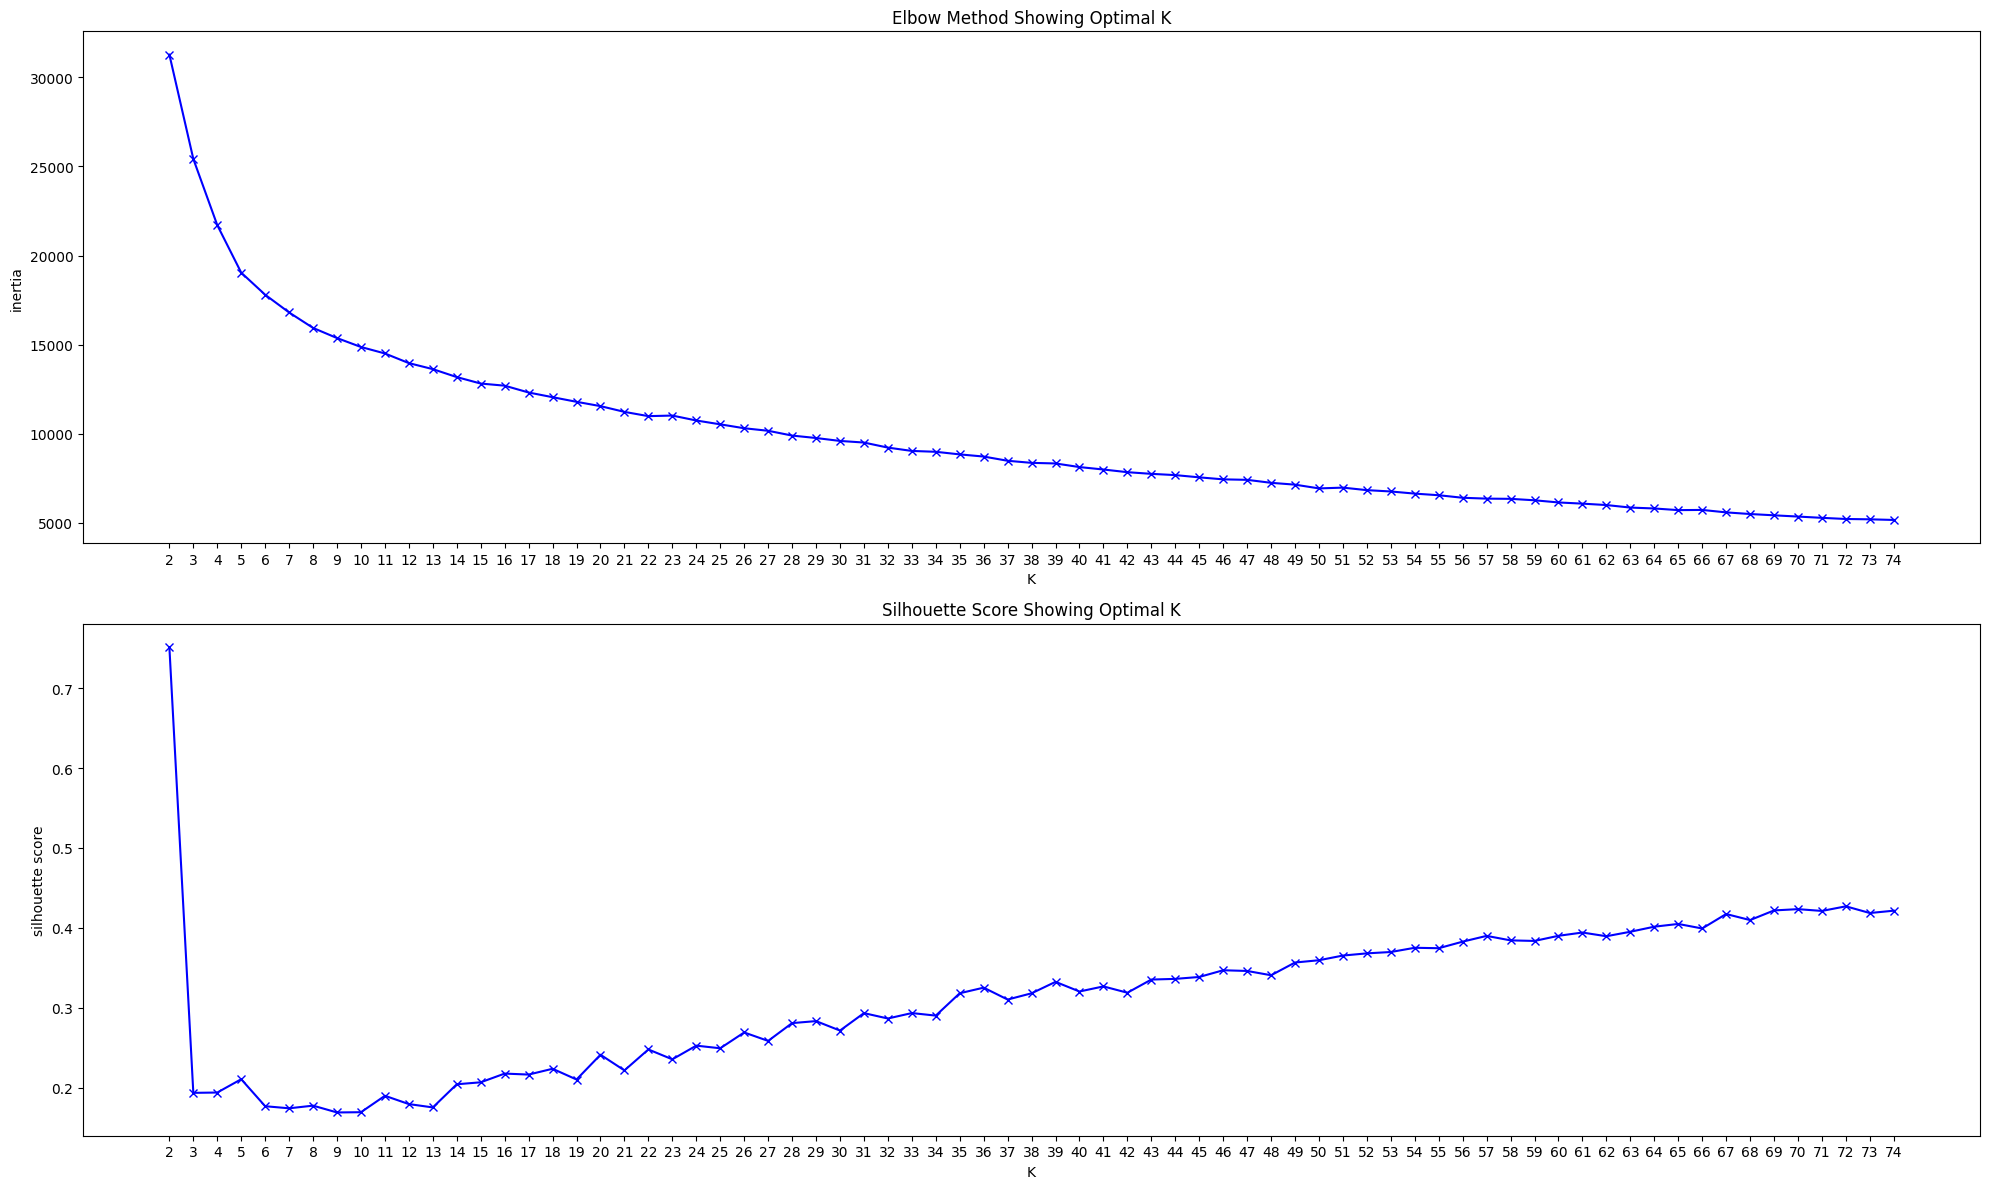

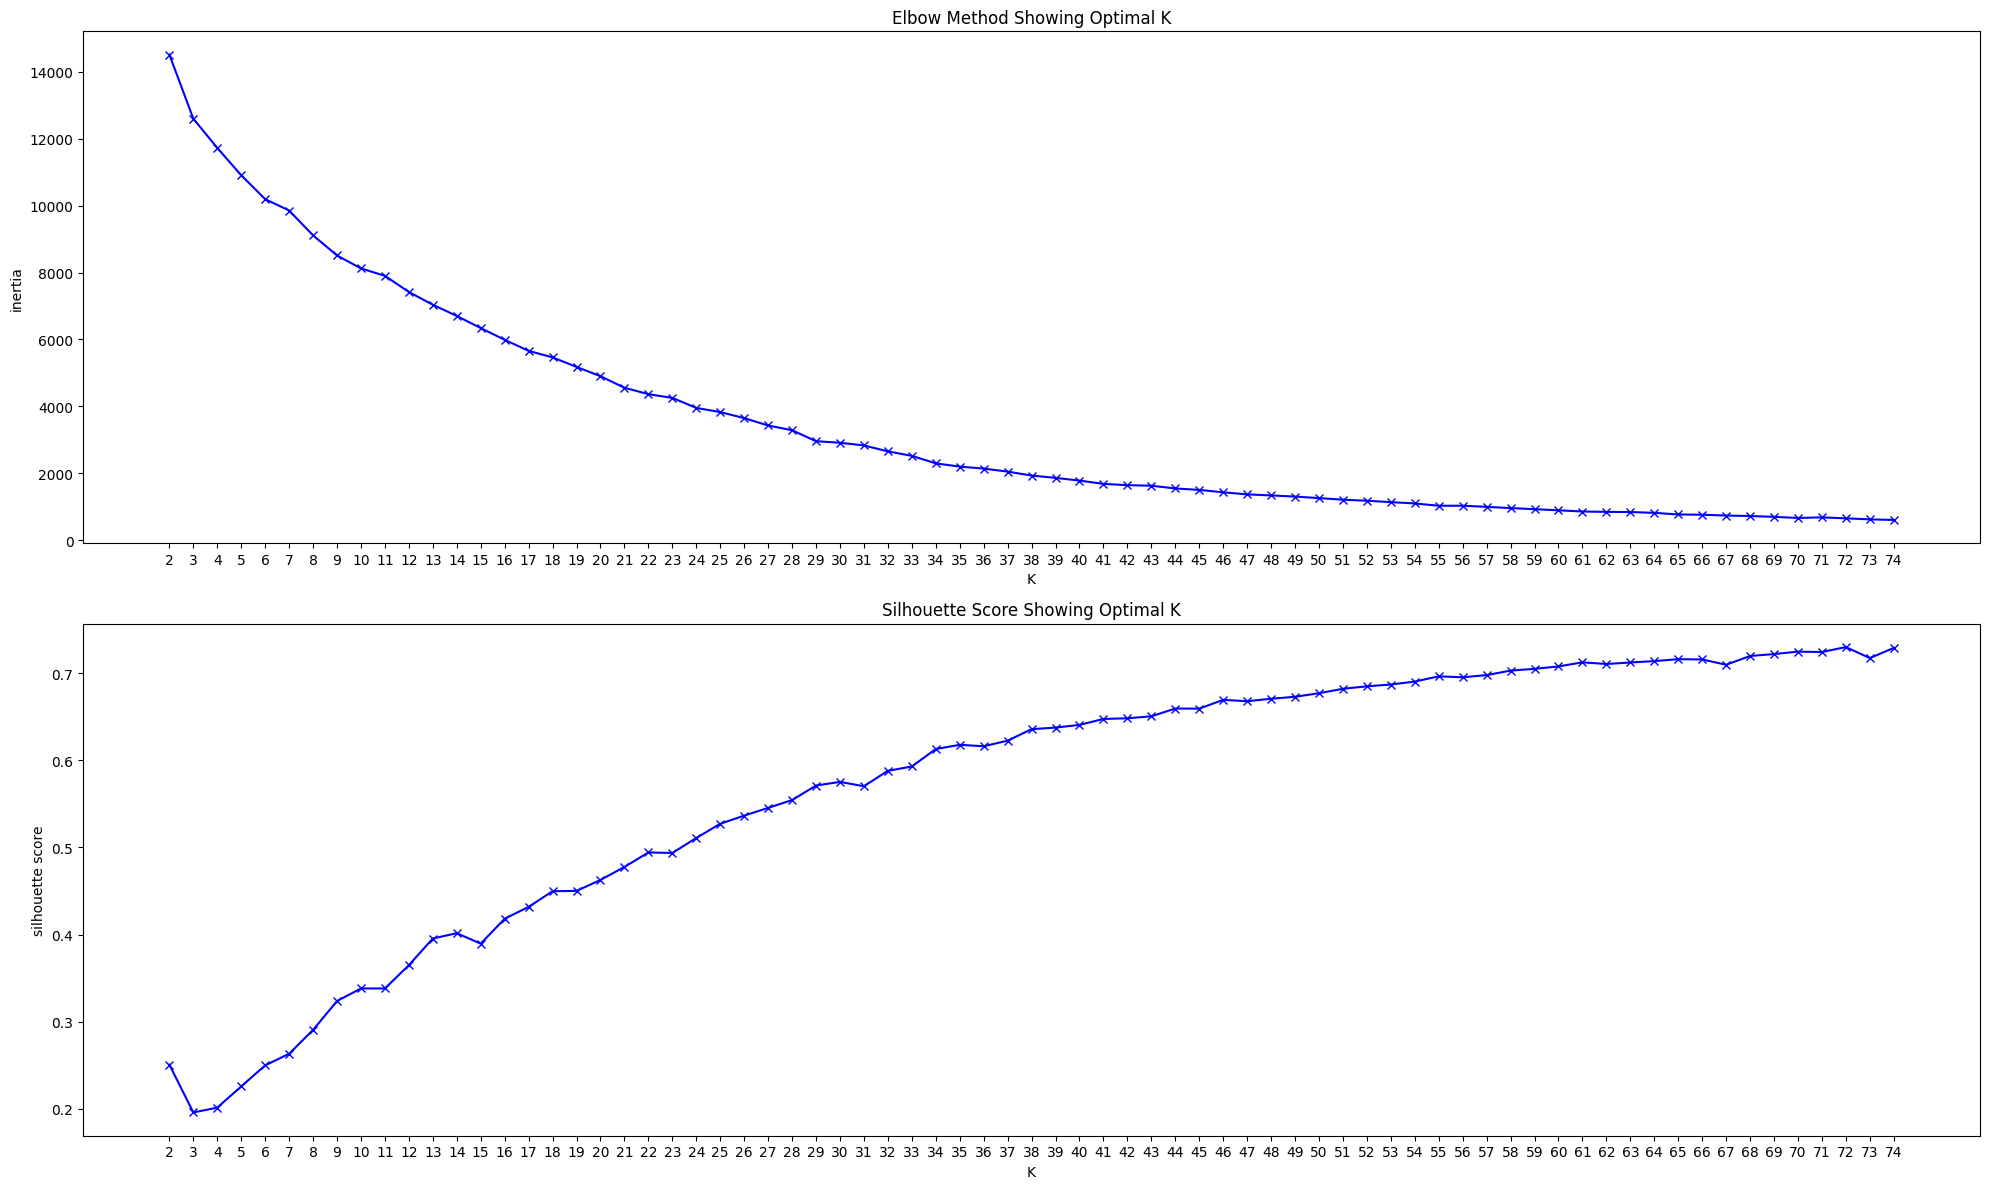

CPU times: user 15min 48s, sys: 5min 37s, total: 21min 26s
Wall time: 14min 21s


In [ ]:
%%time
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for scaler in scalers:
    vg_kmeans_scale = k_means_data(vg_games_data, scaler) # prep data
    graph_optimal_k(vg_kmeans_scale.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1), scaler)

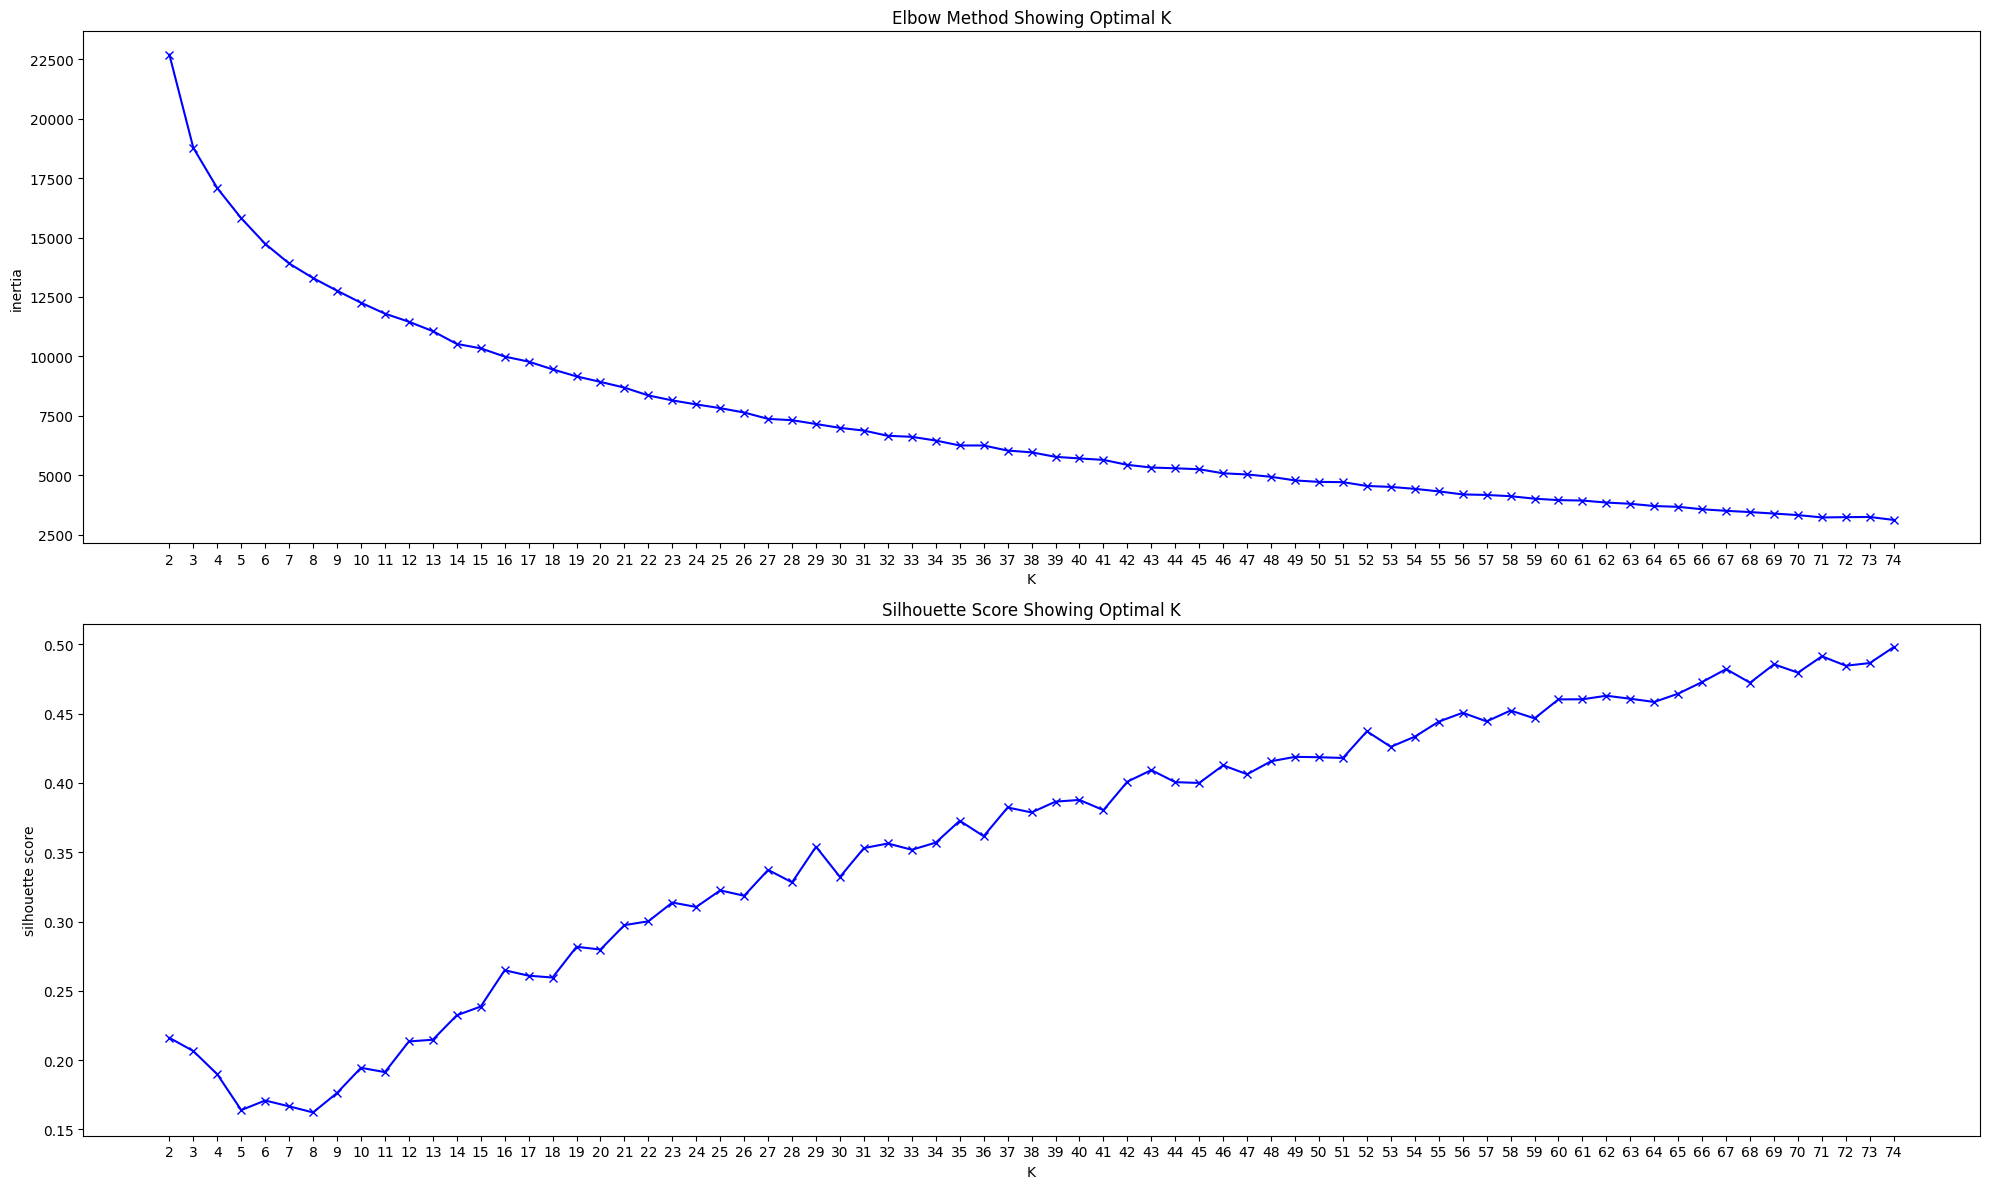

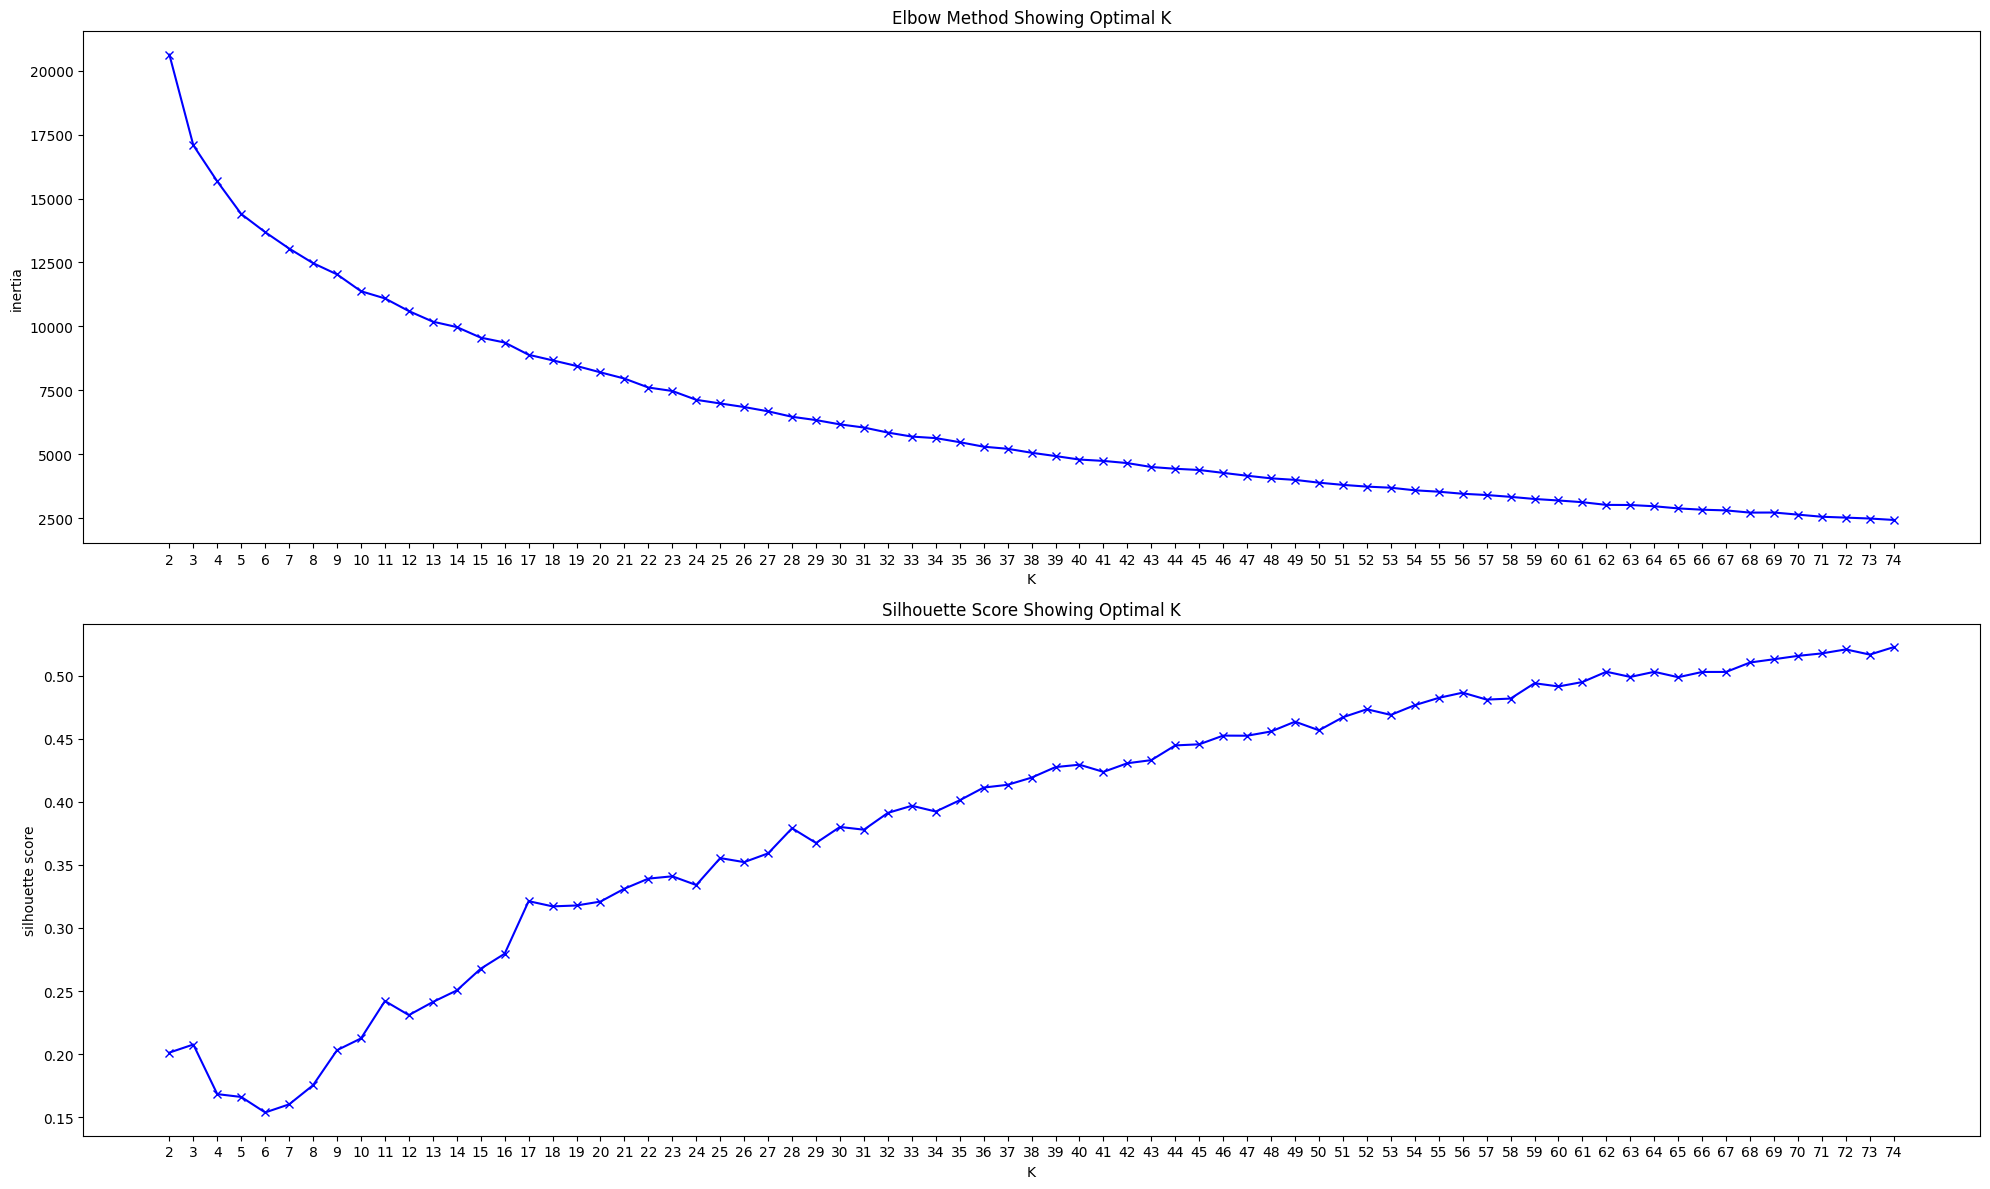

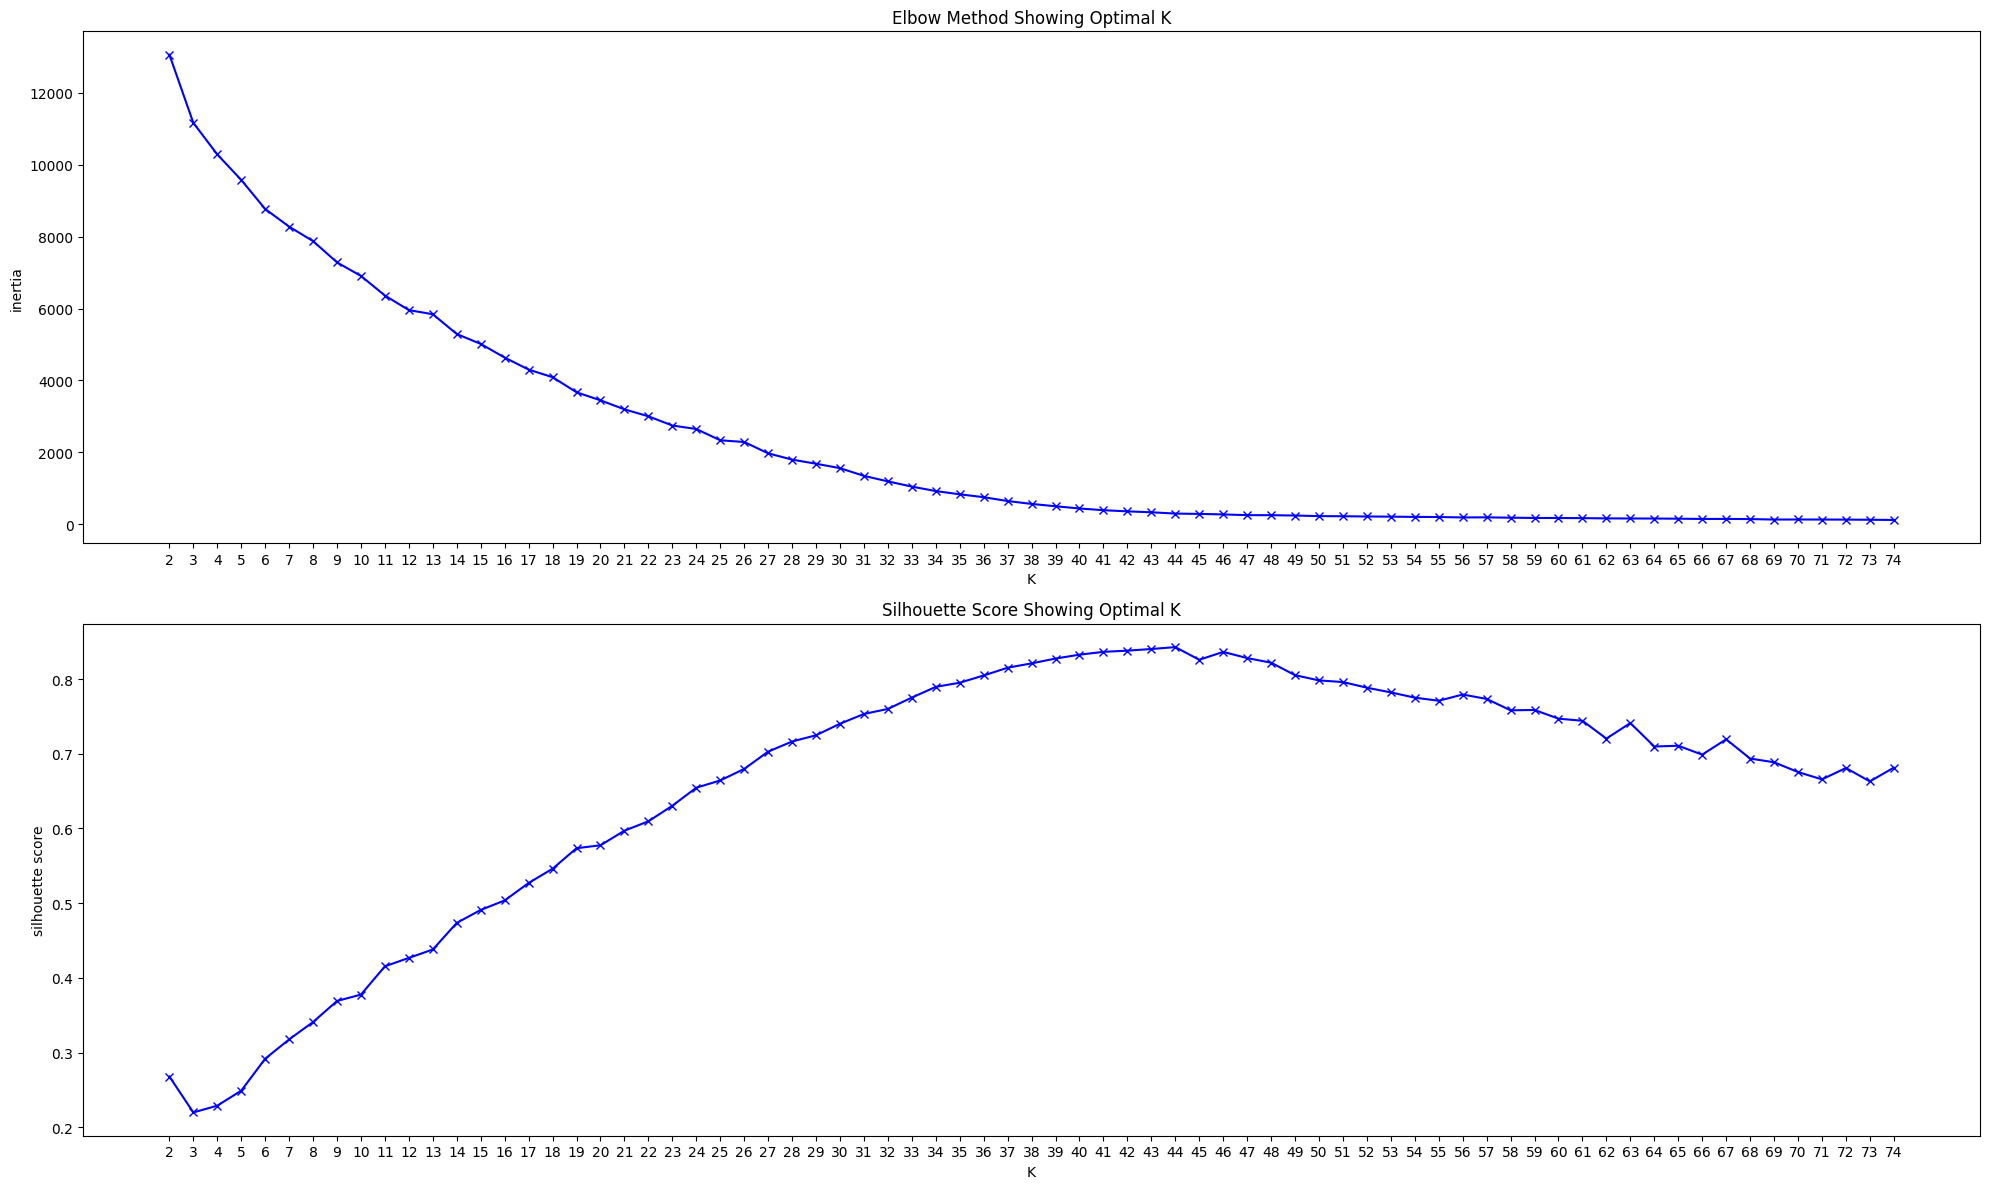

CPU times: user 14min 18s, sys: 5min 23s, total: 19min 41s
Wall time: 13min 18s


In [ ]:
%%time
drop_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'User_Score']

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for scaler in scalers:
    vg_kmeans_scale = k_means_data(vg_games_data, scaler) # prep data
    graph_optimal_k(vg_kmeans_scale.drop(drop_columns, axis=1), scaler)

## K-Means Clustering
### TIme to get cluster predictions

In [ ]:
def format_columns(df):
    df.rename(columns = lambda x : x.split('_')[1] if 'Genre' in x else x, inplace=True)
    df.rename(columns = lambda x : 'Pub_type' if x=='Pub_Profile_Encoded' else x, inplace=True)

def k_means_cluster(vg_data, scaler, k_cluster=2):
    """
    Graphs the clustered data

    Arguments:
        vg_data (pd.DataFrame) - Video_Game dataframe to prep for kmeans
        scaler (sklearn scaler obj) - scaler to normalize numerical cols by
        k_cluster (int) - Number of Clusters for graphed data
    """
    end_line = '\n' + '-'*50 + '\n'

    vg_kmeans_data = k_means_data(vg_data, scaler)
    format_columns(vg_kmeans_data)

    kmeans = KMeans(n_clusters=k_cluster, random_state=42, n_init=10)
    kmeans.fit(vg_kmeans_data)

    clusters = kmeans.predict(vg_kmeans_data)

    print(pd.Series(clusters).value_counts().sort_index(), end=end_line)

    vg_kmeans_data['cluster'] = kmeans.predict(vg_kmeans_data)

    plt.figure(figsize=(16, 12))
    pd.plotting.parallel_coordinates(vg_kmeans_data, 'cluster')

    plt.tight_layout()
    plt.show()

    return vg_kmeans_data['cluster']

### Final Decision on params
 all data except the scores(Critic/User), using MinMax Scaler, grouping into 43 clusters


0     375
1     487
2     333
3     287
4     766
5     692
6     436
7     278
8     248
9     498
10    759
11    381
12    349
13    176
14    257
15    160
16    336
17    410
18    324
19    422
20    338
21    178
22    393
23    329
24    254
25    342
26    292
27    213
28    219
29     65
30    169
31     83
32    146
33    210
34    166
35    175
36    133
37    122
38     55
39     42
40     51
41     55
42     23
Name: count, dtype: int64
--------------------------------------------------


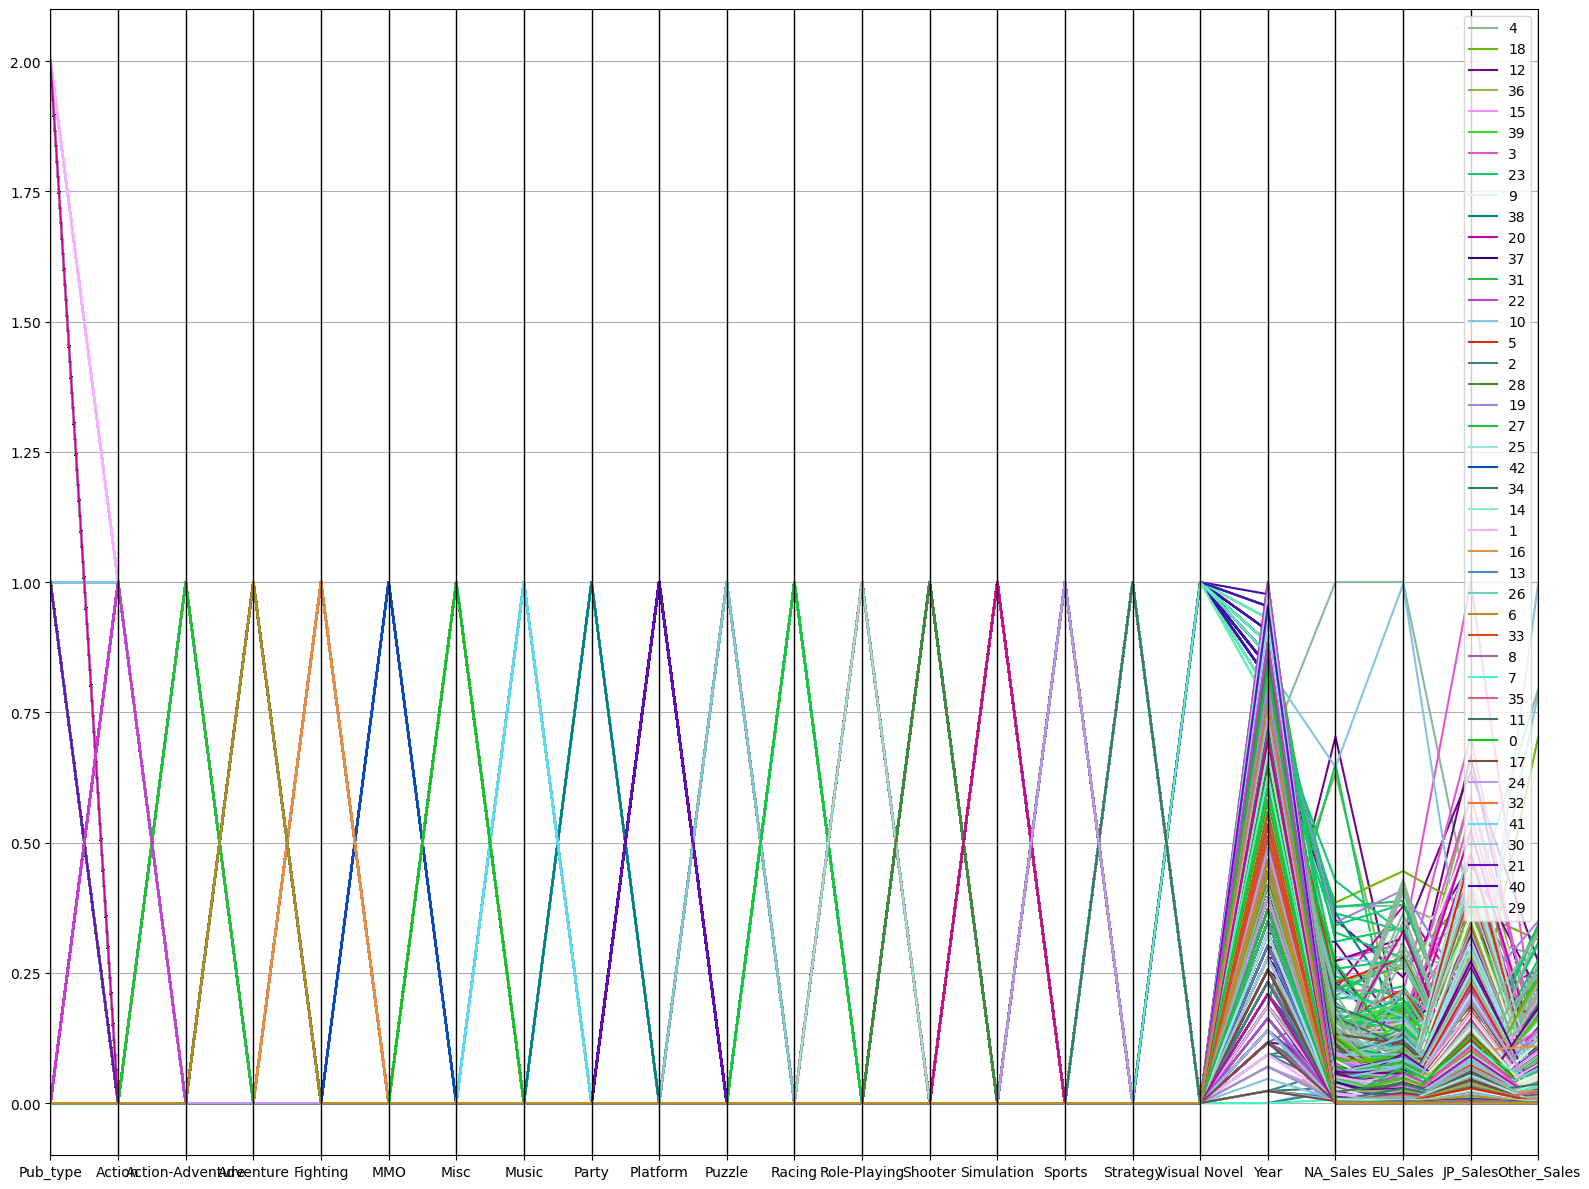

In [ ]:
norm_scale = MinMaxScaler()
num_clusters = 43
cluster_data = k_means_cluster(vg_games_data.drop(['Critic_Score', 'User_Score'], axis=1), norm_scale, num_clusters)

### Now time to Prep tha data for the recommendation system

In [ ]:
vg_games_data.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'User_Score',
       'Publisher_Profile', 'Pub_Profile_Encoded'],
      dtype='object')

In [ ]:
os.listdir('./Recommendation_Data')

['vg_cluster_data.csv']

In [ ]:
def prep_for_recommendaton(vg_games_df, clusters):
    """
    Given the combined game entry data, and the cluster predictions,
    Create the dataframe to be used for the recommendation system NB

    vg_games_df (pd.DataFrame) - Combined game entry dataframe
    clusters (pd.series[int]) - cluster predictions for each entry
    """
    # Add cluster to dataframe
    vg_games_df["Cluster"] = clusters

    # drop encoded publisher profile
    vg_games_df.drop(['Pub_Profile_Encoded'], axis=1, inplace=True)

    # store onto csv file
    vg_games_df.to_csv('./Recommendation_Data/vg_cluster_data.csv', index=False)

prep_for_recommendaton(vg_games_data, cluster_data)
vg_games_data

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,User_Score,Publisher_Profile,Cluster
0,32,Wii Sports,Wii,2006,Sports,Nintendo,41.36,29.02,3.77,8.51,7.7,0.0,High Profile,4
1,52,Mario Kart 8 Deluxe,NS,2017,Racing,Nintendo,5.05,4.98,2.11,0.91,9.3,0.0,High Profile,18
2,81,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,10.0,8.2,High Profile,12
3,87,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.91,12.92,3.80,3.35,8.2,9.1,High Profile,18
4,94,Tetris,"GB, NES",1989,Puzzle,Nintendo,26.17,2.95,6.03,0.69,0.0,0.0,High Profile,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,20793,1/2 Summer +,PSP,2013,Misc,Kaga Create,0.00,0.00,0.01,0.00,0.0,0.0,Low Profile,0
12023,20797,Pippa Funnell 2: Farm Adventures,DS,2007,Simulation,Ubisoft,0.00,0.01,0.00,0.00,0.0,0.0,High Profile,20
12024,20798,Irotoridori no Sekai: World's End Re-Birth,PSV,2015,Action,HuneX,0.00,0.00,0.01,0.00,0.0,0.0,Low Profile,22
12025,20799,PDC World Championship Darts 2009,Wii,2009,Sports,Oxygen Interactive,0.00,0.01,0.00,0.00,0.0,0.0,Low Profile,24


### Lets also Inspect Cluster Data;
See what clusters are being grouped by

In [ ]:
vg_recommend_data = pd.read_csv('./Recommendation_Data/vg_cluster_data.csv')

In [ ]:
def max_sales_columns(row):
    """
    custom agg function for rec data to get sales column with most sales'
    if there is a tie, include all columns in the tie.

    Returns: pd.series - series with sales column(s) with most sales for game entry
    """
    # Get the sales values for each region
    sales_values = row[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

    # Determine the maximum sales value
    max_sales_value = sales_values.max()

    # Find columns where the sales value equals the maximum
    max_columns = sorted(sales_values[sales_values == max_sales_value].index.tolist())

    return pd.Series({
        'Max_Sales_Columns': ' ; '.join(max_columns)
    })

In [ ]:
def recommend_data_info():
    """
    Prints some info about each cluster
    """
    for cluster in np.sort(vg_recommend_data['Cluster'].unique()):
        cluster_filter = vg_recommend_data['Cluster'] == cluster
        cluster_data = vg_recommend_data[cluster_filter]

        print(f'{cluster=}',  end='\n'+'-'*15+'\n')
        print(cluster_data['Publisher'].value_counts()[:10], end='\n'+'-'*20+'\n')
        print(cluster_data['Publisher_Profile'].value_counts(), end='\n'+'-'*20+'\n')
        print(cluster_data['Genre'].value_counts(),end = '\n'+'-'*20+'\n')

        max_sales_agg = cluster_data.apply(max_sales_columns, axis=1)
        print(max_sales_agg.value_counts(), end = '\n'+'-'*50+'\n')

recommend_data_info()

cluster=0
---------------
Publisher
MTV Games             13
Microsoft             13
DSI Games             13
UFO Interactive       11
2K Play                9
Mindscape              8
Hasbro Interactive     8
Zoo Games              8
Nordic Games           8
Hackberry              7
Name: count, dtype: int64
--------------------
Publisher_Profile
Low Profile    375
Name: count, dtype: int64
--------------------
Genre
Misc    375
Name: count, dtype: int64
--------------------
Max_Sales_Columns  
NA_Sales               188
JP_Sales               138
EU_Sales                45
EU_Sales ; NA_Sales      4
Name: count, dtype: int64
--------------------------------------------------
cluster=1
---------------
Publisher
Activision                     96
THQ                            79
Ubisoft                        65
Konami                         63
Sony Computer Entertainment    56
Sega                           46
Electronic Arts                42
Nintendo                       40
Name:

## TIme for Recommendation Model!
### Go to Video Games Recommendations notebook now